# [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for MNIST
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [609]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
import pyxu.runtime as pxrt
import cupy as cp
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import pyxu.abc as pxa

In [610]:
def show_images(images, title="", figsize=(8, 50)):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.permute(1,2,0).numpy() for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=figsize)
    rows = len(images)//5
    cols = len(images)//20

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        print(r)
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    plt.tight_layout()
    # Showing the figure
    plt.show()

In [611]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [612]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [613]:
class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c))

def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2), 
                         MyConv((in_c//2, size, size), in_c//2, in_c//4),
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))

In [614]:
class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock(size, in_c, 10)
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock(size//2, 10, 20)
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock(size//4, 20, 40)
        self.down3 = nn.Conv2d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv((40, size//8, size//8), 40, 20),
            MyConv((20, size//8, size//8), 20, 20),
            MyConv((20, size//8, size//8), 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp(size//4, 80)
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp(size//2, 40)
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock(size, 20, 10)
        self.conv_out = nn.Conv2d(10, out_c, 3, 1, 1)

    def forward(self, x, t): # x is (bs, in_c, size, size) t is (bs)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (bs, 20, size/4, size/4)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (bs, 80, size/8, size/8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (bs, 20, size/8, size/8)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (bs, 40, size/4, size/4)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (bs, 20, size, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (bs, 10, size, size)
        out = self.conv_out(out) # (bs, out_c, size, size)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

## ---------------------------- testing new architecture to handle non square images

In [615]:
def sinusoidal_embedding(n, d):
    """Standard 1D sinusoidal time embedding."""
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)
    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])
    return embedding

class MyConv(nn.Module):
    """Conv → (optional) GroupNorm → Activation."""
    def __init__(self, in_c, out_c, kernel_size=3, stride=1, padding=1,
                 activation=None, normalize=True):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.norm = nn.GroupNorm(1, out_c) if normalize else nn.Identity()
        self.act  = nn.SiLU() if activation is None else activation

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return self.act(x)

def MyTinyBlock(in_c, out_c):
    """3× (MyConv)."""
    return nn.Sequential(
        MyConv(in_c,  out_c),
        MyConv(out_c, out_c),
        MyConv(out_c, out_c),
    )

def MyTinyUp(in_c):
    """
    3× (MyConv) that progressively halves channels:
      in_c → in_c//2 → in_c//4 → in_c//4
    """
    return nn.Sequential(
        MyConv(in_c,       in_c // 2),
        MyConv(in_c // 2,  in_c // 4),
        MyConv(in_c // 4,  in_c // 4),
    )

class MyTinyUNet(nn.Module):
    """
    A 3‐down / 3‐up U-Net with tiny blocks,
    now agnostic to H×W (must be divisible by 8).
    """
    def __init__(self, in_c=1, out_c=1, n_steps=1000, time_emb_dim=100):
        super().__init__()

        # time embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.weight.requires_grad_(False)

        # ↓↓↓ Down path ↓↓↓
        self.te1 = self._make_te(time_emb_dim, in_c)
        self.b1  = MyTinyBlock(in_c,  10)
        self.down1 = nn.Conv2d(10, 10, kernel_size=4, stride=2, padding=1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2  = MyTinyBlock(10, 20)
        self.down2 = nn.Conv2d(20, 20, kernel_size=4, stride=2, padding=1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3  = MyTinyBlock(20, 40)
        self.down3 = nn.Conv2d(40, 40, kernel_size=4, stride=2, padding=1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv(40, 20),
            MyConv(20, 20),
            MyConv(20, 40),
        )

        # ↑↑↑ Up path ↑↑↑
        self.up1 = nn.ConvTranspose2d(40, 40, kernel_size=4, stride=2, padding=1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4  = MyTinyUp(80)

        self.up2 = nn.ConvTranspose2d(20, 20, kernel_size=4, stride=2, padding=1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5  = MyTinyUp(40)

        self.up3 = nn.ConvTranspose2d(10, 10, kernel_size=4, stride=2, padding=1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out  = MyTinyBlock(20, 10)

        self.conv_out = nn.Conv2d(10, out_c, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        """
        x: (B, in_c, H, W)
        t: (B,) integer timesteps
        """
        # embed time
        te = self.time_embed(t)  # (B, time_emb_dim)
        B  = x.size(0)

        # down 1
        h1 = self.b1(x + self.te1(te).view(B, -1, 1, 1))
        h2 = self.b2(self.down1(h1) + self.te2(te).view(B, -1, 1, 1))
        h3 = self.b3(self.down2(h2) + self.te3(te).view(B, -1, 1, 1))

        # bottleneck
        h_mid = self.b_mid(self.down3(h3) + self.te_mid(te).view(B, -1, 1, 1))

        # up 1
        u1 = torch.cat([h3, self.up1(h_mid)], dim=1)
        u1 = self.b4(u1 + self.te4(te).view(B, -1, 1, 1))

        # up 2
        u2 = torch.cat([h2, self.up2(u1)], dim=1)
        u2 = self.b5(u2 + self.te5(te).view(B, -1, 1, 1))

        # up 3
        u3 = torch.cat([h1, self.up3(u2)], dim=1)
        u3 = self.b_out(u3 + self.te_out(te).view(B, -1, 1, 1))

        return self.conv_out(u3)

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out),
        )

(120, 40)


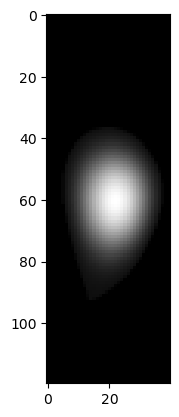

In [616]:
data = np.load('data/sxr_plasma_lower_res/sxr_samples_coarse.npy')
plt.imshow(data[125], cmap='gray')
print(data[125].shape)

torch.Size([2, 1, 32, 32])


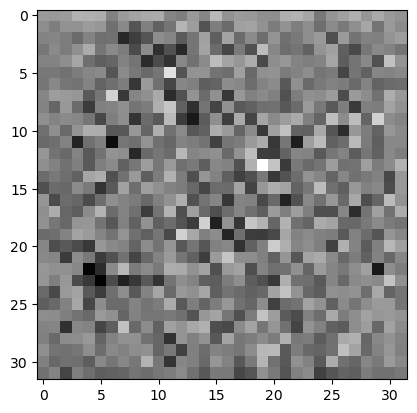

In [617]:
# test output of nn with random input
model = MyTinyUNet().to(device)
x = torch.randn(2, 1, 32, 32).to(device)
t = torch.randint(0, 1000, (2,)).to(device)
y = model(x, t)
print(y.shape)
plt.imshow(y[0, 0].detach().cpu().numpy(), cmap="gray")
plt.show()

In [618]:
bs = 3
x = torch.randn(bs,1,120,40)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1)

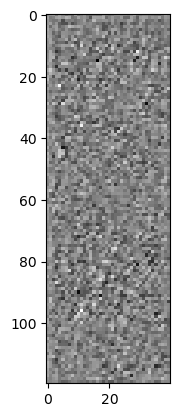

In [619]:
y = unet(x,timesteps)
y.shape
plt.imshow(y[0,0].detach().cpu().numpy(), cmap="gray")
plt.show()

In [620]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps] # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
        s1 = s1.reshape(-1,1,1,1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1) # (bs, 1, 1, 1)
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample
    
    def posterior_sample(self, model_output, timestep, sample, linear_operator, y):
        # y is the observation done with the linear operator
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        #return pred_prev_sample

        chainrule = False
        with pxrt.Precision(pxrt.Width.SINGLE):
            # convert y to cupy array of shape (,-1)
            
            if chainrule:
                v1 = cp.from_dlpack(pred_prev_sample.detach()).reshape(-1)
                v2 = cp.array(y).reshape(-1)
                Ax = linear_operator.apply(v1)
                v3 = (Ax - v2)**2
                l2_error = cp.sum(v3)
                zeta = 1/torch.sqrt(torch.tensor(l2_error))

                f = lambda x : self.step(model_output, timestep, x)
                #A^T(y-Ax)
                v = linear_operator.adjoint(linear_operator.apply(cp.from_dlpack(pred_prev_sample.detach()).reshape(-1))-cp.array(y).reshape(-1))
                v = torch.tensor(v).reshape(pred_prev_sample.shape).to(self.device)
                # make pred_prev_sample.shape[0] times stack of v
                #v = torch.stack([v for i in range(pred_prev_sample.shape[0])]).to(self.device)
                gradx_l2_error = torch.autograd.functional.vjp(f, sample, v=v)[1]

            else:
                B, C, H, W = pred_prev_sample.shape
                Ax = torch.matmul(pred_prev_sample.reshape(B, H*W), linear_operator.T)
                #l2_error = torch.sum(((linear_operator@((pred_prev_sample.reshape(B, H*W)).T)).T - y.reshape(-1))**2)
                l2_error = torch.sum((Ax - y.reshape(-1))**2)
                zeta = 1/torch.sqrt(l2_error)
                gradx_l2_error = torch.autograd.grad(outputs=l2_error, inputs=sample)[0]
           
        # masking for stochastic gradient 0 or 1
        pred_prev_sample -= 2*zeta*gradx_l2_error
        try:
            print('res', torch.linalg.norm(sample-pred_prev_sample)/torch.linalg.norm(sample))
        except:
            print('fail')

        return pred_prev_sample

In [621]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [622]:
network = MyTinyUNet(in_c =1, out_c =1)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [623]:
bs = 5
x = torch.randn(bs,1,120,40).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [624]:
y = model.add_noise(x,x,timesteps)
y.shape

torch.Size([5, 1, 120, 40])

In [625]:
y = model.step(x,timesteps[0],x)
y.shape

torch.Size([5, 1, 120, 40])

You can check that all the parameters of the UNet `network` are indeed parameters of the DDPM `model` like this:

In [626]:
for n, p in model.named_parameters():
    print(n, p.shape)

network.time_embed.weight torch.Size([1000, 100])
network.te1.0.weight torch.Size([1, 100])
network.te1.0.bias torch.Size([1])
network.te1.2.weight torch.Size([1, 1])
network.te1.2.bias torch.Size([1])
network.b1.0.conv.weight torch.Size([10, 1, 3, 3])
network.b1.0.conv.bias torch.Size([10])
network.b1.0.norm.weight torch.Size([10])
network.b1.0.norm.bias torch.Size([10])
network.b1.1.conv.weight torch.Size([10, 10, 3, 3])
network.b1.1.conv.bias torch.Size([10])
network.b1.1.norm.weight torch.Size([10])
network.b1.1.norm.bias torch.Size([10])
network.b1.2.conv.weight torch.Size([10, 10, 3, 3])
network.b1.2.conv.bias torch.Size([10])
network.b1.2.norm.weight torch.Size([10])
network.b1.2.norm.bias torch.Size([10])
network.down1.weight torch.Size([10, 10, 4, 4])
network.down1.bias torch.Size([10])
network.te2.0.weight torch.Size([10, 100])
network.te2.0.bias torch.Size([10])
network.te2.2.weight torch.Size([10, 10])
network.te2.2.bias torch.Size([10])
network.b2.0.conv.weight torch.Size(

In [627]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()

In [628]:
'''root_dir = './data/'
transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])

medmnist=False

if medmnist:
    from medmnist import TissueMNIST 
    dataset = TissueMNIST(split='train', download=True, transform=transform01)
    print('shape of images', dataset[0][0].shape)
    #only keep 60000 images
    dataset = torch.utils.data.Subset(dataset, range(60000))

else:
    dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)
    print('shape of images', dataset[0][0].shape)

dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=10) #4096
print(len(dataloader))
print(dataloader.dataset)'''

"root_dir = './data/'\ntransform01 = torchvision.transforms.Compose([\n        torchvision.transforms.Resize(32),\n        torchvision.transforms.ToTensor(),\n        torchvision.transforms.Normalize((0.5), (0.5))\n    ])\n\nmedmnist=False\n\nif medmnist:\n    from medmnist import TissueMNIST \n    dataset = TissueMNIST(split='train', download=True, transform=transform01)\n    print('shape of images', dataset[0][0].shape)\n    #only keep 60000 images\n    dataset = torch.utils.data.Subset(dataset, range(60000))\n\nelse:\n    dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)\n    print('shape of images', dataset[0][0].shape)\n\ndataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=10) #4096\nprint(len(dataloader))\nprint(dataloader.dataset)"

In [646]:
a = np.load('data/sxr_profiles_coarse/sxr_sample_99736.npy')


N=int(75000)
dataset_fusion = np.zeros((N,120,40))
for i in range(N):
    if i%int(1e4)==0:
        print("processing {}-th sample".format(i))
        dataset_fusion[i,:,:] = np.load('data/sxr_profiles_coarse/sxr_sample_'+str(i)+'.npy')

dataset_fusion = torch.tensor(dataset_fusion).float().reshape(dataset_fusion.shape[0], 1, dataset_fusion.shape[1], dataset_fusion.shape[2])

transform01 = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.5), (0.5))
    ])

dataset = torch.utils.data.TensorDataset(dataset_fusion)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True, num_workers=10)

print(len(dataloader))

processing 0-th sample


EOFError: No data left in file

0
1
2
3
4
5


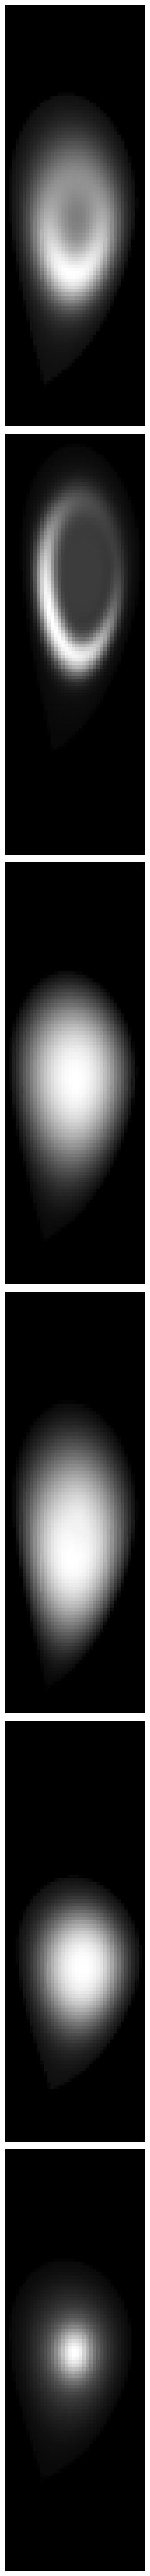

In [630]:
for b in dataloader:
    batch = b[0]
    break

bn = [b for b in batch[:100]]
 
show_images(bn, "origin")

In [631]:
train_ = False

if train_ == True:
    learning_rate = 1e-3
    num_epochs = 300
    num_timesteps = 1000
    network = MyTinyUNet()
    network = network.to(device)
    model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)   

    # save the model
    
    torch.save(model.state_dict(), 'ddpm_fusion.pth') 


else:
    model.load_state_dict(torch.load("ddpm_fusion.pth"))


In [632]:
def generate_image(ddpm, sample_size, channel, shape):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, shape[0], shape[1]).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size,1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t==500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [633]:
def posterior_generate_image(ddpm, sample_size, channel, shape, linear_operator, y, initial_guess = None):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()


    timesteps = list(range(ddpm.num_timesteps))[::-1]
    sample = torch.randn(sample_size, channel, shape[0], shape[1]).to(device)
    if initial_guess is not None:
        initial_guess = torch.tensor(initial_guess).to(device).float()
        sample = initial_guess.repeat(sample_size, channel, 1, 1)
    sample.requires_grad = True
    
    for i, t in enumerate(tqdm(timesteps)):
        #with torch.no_grad(): #comment when using chainrule
        time_tensor = (torch.ones(sample_size,1) * t).long().to(device)
        residual = ddpm.reverse(sample, time_tensor)#.to(device)
        #sample = ddpm.step(residual, time_tensor[0], sample)
        sample = ddpm.posterior_sample(residual, time_tensor[0], sample, linear_operator, y)

        if t==500:
            for i in range(sample_size):
                frames_mid.append(sample[i].detach().cpu())

    for i in range(sample_size):
        frames.append(sample[i].detach().cpu())
        
    return frames, frames_mid

In [634]:
generated, generated_mid = generate_image(model.to(device), 100, 1, (120, 40))

  0%|          | 0/1000 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


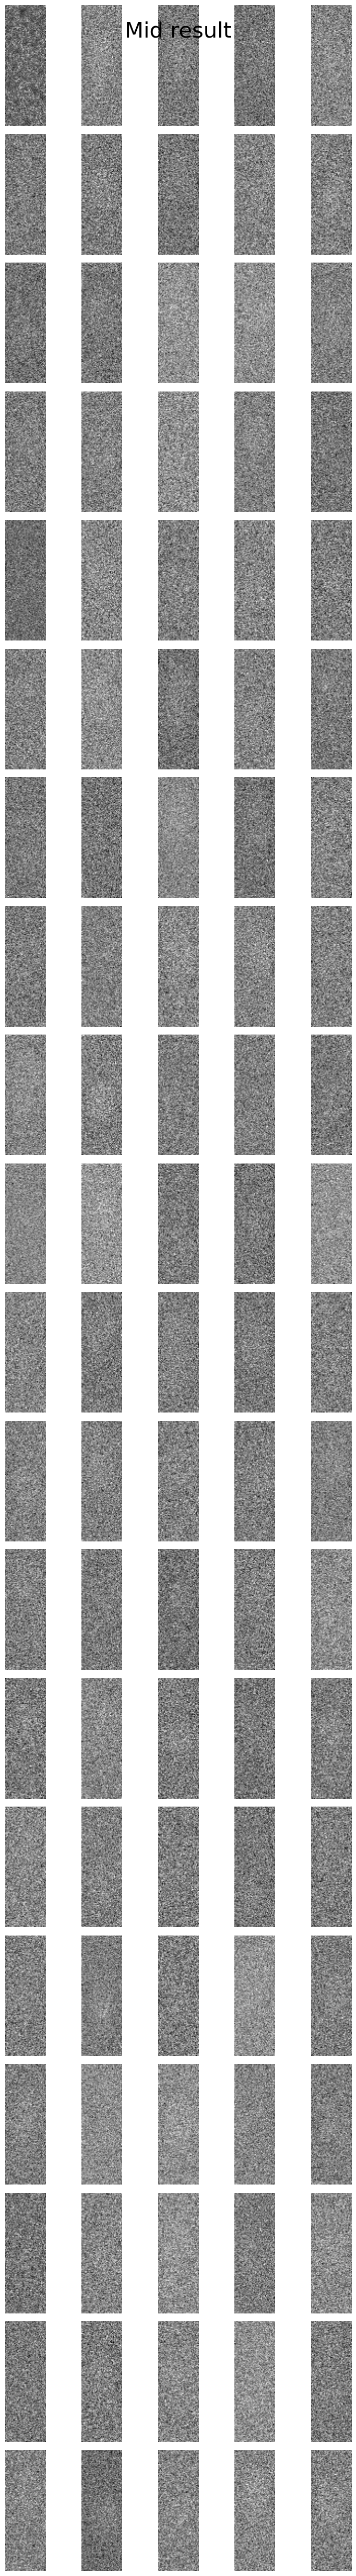

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


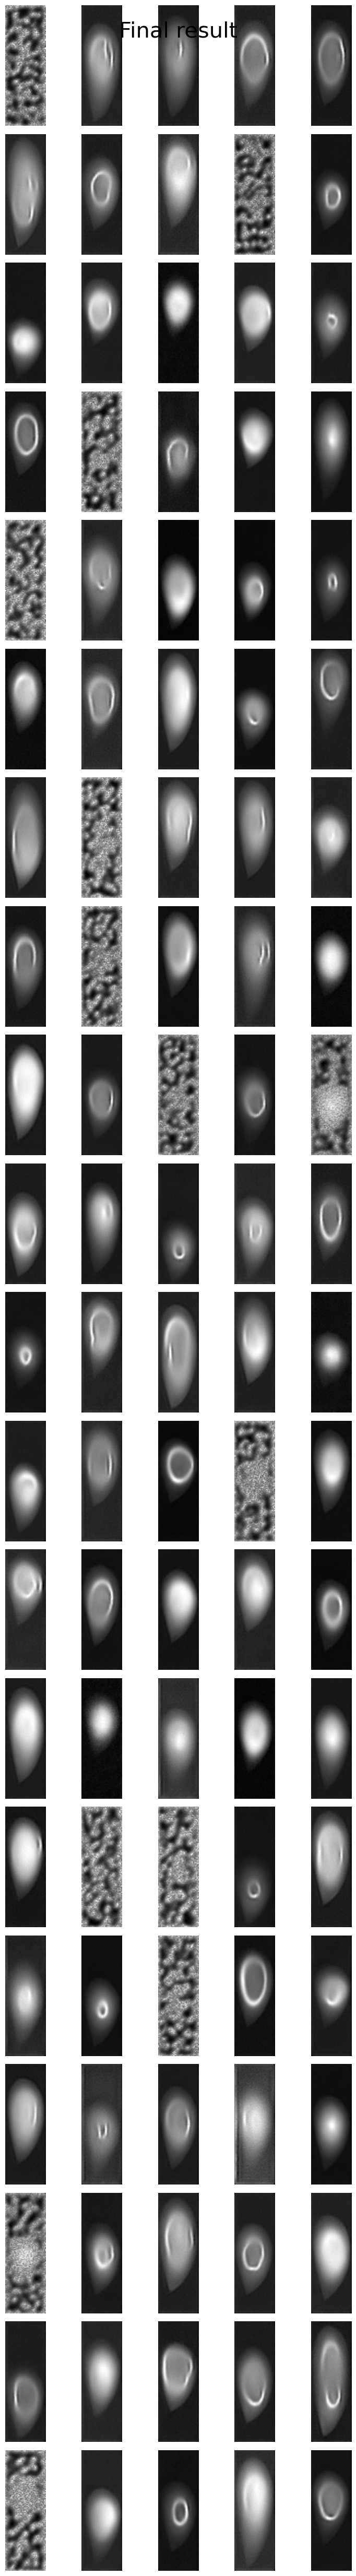

In [635]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")

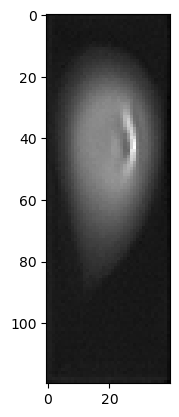

In [588]:
generated = np.array(generated)
plt.figure()
plt.imshow(generated[22, 0, :, :], cmap='gray')
plt.show()

In [589]:
def rescale(x):
    return (x+1)/2

def show_images_rescale(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [rescale((im.permute(1,2,0)).numpy()) for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                #plt.imshow(images[idx].reshape(pixel, pixel, n_channels), cmap="gray")
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

## Conditional posterior sampling with X-ray projections

In [590]:
'''# Select on sample on antoher dataset, with train=False
if medmnist:
    dataset_test = TissueMNIST(split='test', download=True, transform=transform01)
    dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=True, num_workers=10)
else:   
    dataset_test = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transform01, download=True)
    dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=True, num_workers=10)'''

"# Select on sample on antoher dataset, with train=False\nif medmnist:\n    dataset_test = TissueMNIST(split='test', download=True, transform=transform01)\n    dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=True, num_workers=10)\nelse:   \n    dataset_test = torchvision.datasets.MNIST(root=root_dir, train=False, transform=transform01, download=True)\n    dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=True, num_workers=10)"

In [591]:
for b in dataloader:
    batch = b[0]
    break

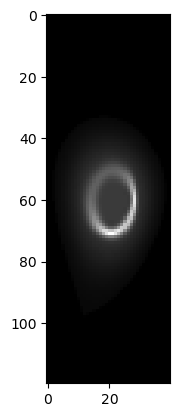

In [592]:
x_gt_np = rescale(batch[4].permute(1,2,0).numpy())
#save gt
#np.save('gt.npy', x_gt_np)
#load gt
#x_gt_np = np.load('gt.npy')
plt.imshow(x_gt_np, cmap="gray")

[-60. -54. -48. -42. -36. -30. -24. -18. -12.  -6.   0.   6.  12.  18.
  24.  30.  36.  42.  48.  54.]
range of y 0.0 68.06907


Text(0.5, 1.0, '/!\\ inverse crime : Pseudo inverse CGD')

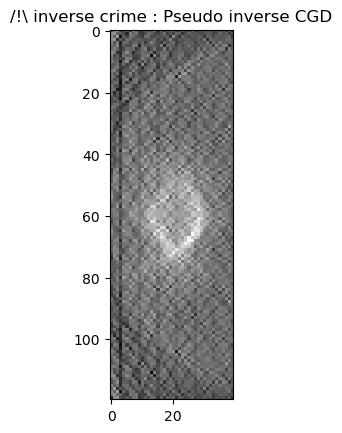

In [593]:
# create data y with X-ray operator
import cupy as cp

x_gt_np_ = x_gt_np[:,:,0]
v_shape = x_gt_np_.shape
N_side = v_shape[0]
pitch = 1.
N_angle  = 20
N_offset = 100 

# Let's build the necessary components to instantiate the operator . ========================
angles = np.linspace(-np.pi/3, np.pi/3, N_angle, endpoint=False) #pi/10 pour mnist
print(angles * 180 / np.pi)

n = np.stack([np.cos(angles), np.sin(angles)], axis=1)

t        = n[:, [1, 0]] * np.r_[-1, 1]  # <n, t> = 0
t_max    = pitch * (N_side-1) / 2 * 1.  # 10% over ball radius
t_offset = np.linspace(-t_max, t_max, N_offset, endpoint=True)

n_spec  = np.broadcast_to(n.reshape(N_angle, 1, 2), (N_angle, N_offset, 2))  # (N_angle, N_offset, 2)
t_spec  = t.reshape(N_angle, 1, 2) * t_offset.reshape(N_offset, 1)  # (N_angle, N_offset, 2)
t_spec += pitch * N_side / 2  # Move anchor point to the center of volume.
extra   = np.ones((1,N_angle*N_offset,1))
origin  = (0., 0.)
pitch   = (1.,1.)

# Convert to cupy arrays
t_spec  = cp.array(t_spec)
n_spec  = cp.array(n_spec)

xray = pxr.XRayTransform.init(
    arg_shape=v_shape,
    t_spec=t_spec.reshape(-1,2), 
    n_spec=n_spec.reshape(-1,2),
    origin=origin,
    pitch=pitch,
)

x_gt_cp = cp.array(x_gt_np_)
with pxrt.Precision(pxrt.Width.SINGLE):
    y = xray.apply(x_gt_cp.reshape(-1))
print('range of y', cp.min(y), cp.max(y))
y += cp.random.normal(0, 0.00003, y.shape)

# basic reconstruction
stop_crit = pxst.MaxIter(50)
x_rec_pinv = xray.pinv(y, damp=10 , kwargs_fit=dict(stop_crit=stop_crit))
plt.imshow(x_rec_pinv.get().reshape(120, 40), cmap="gray") 
plt.title("/!\ inverse crime : Pseudo inverse CGD")     

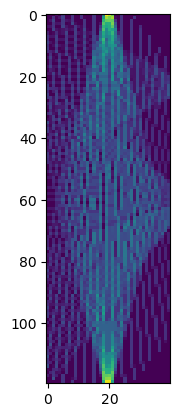

In [594]:
import scipy.sparse as sp
A_np = sp.load_npz("data/sxr_plasma_lower_res/forward_model_coarse.npz")
import cupyx.scipy.sparse as csp
A_cp = csp.csr_matrix(A_np)
A_dense = A_cp.todense()
A_torch = torch.tensor(A_dense).float().to(device)
#A_torch_sparse = A_torch.to_sparse()
x_gt_cp = torch.tensor(x_gt_cp, device = A_torch.device).reshape(-1)

y = A_torch @ x_gt_cp

back_proj = A_torch.T @ y.reshape(-1)

plt.imshow(back_proj.reshape(120,40).cpu())

In [515]:
from pyxu.operator import Gradient, SquaredL2Norm, L1Norm, L21Norm, PositiveL1Norm, PositiveOrthant
from tqdm.notebook import trange, tqdm
from pyxu.operator.interop import from_torch

def power_iteration(A, tol: int = 1e-3, maxiter: int = 1000):
    # Ideally choose a random vector
    # To decrease the chance that our vector
    # Is orthogonal to the eigenvector
    b_k = cp.random.rand(np.prod(v_shape))
    rel_err = tol*10
    eigenval_max_old = 0

    for i in range(maxiter):

        # calculate the matrix-by-vector product Ab
        b_k1 = A((b_k).reshape(-1))
        # calculate the norm
        b_k1_norm = cp.linalg.norm(b_k1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm        

        eigenval_max = cp.dot(b_k.T, A(b_k)) / cp.dot(b_k.T, b_k) # Rayleigh quotient
        rel_err = cp.abs(eigenval_max - eigenval_max_old)
        eigenval_max_old = eigenval_max

        print('Iteration : ', i, ' | Eigenvalue : ', eigenval_max, ' | Relative error : ', rel_err)

        if rel_err < tol:

            return eigenval_max
        
    return eigenval_max

In [516]:
L_loss = 615.5893219106578
compute_lipschitz_loss = True
print(y.size)
if compute_lipschitz_loss:
    loss = (0.5 * SquaredL2Norm(dim=y.size) * xray).grad
    L_loss = power_iteration(loss, tol=1)
    print('L_loss :', L_loss)

2000
Iteration :  0  | Eigenvalue :  1190.0240659572703  | Relative error :  1190.0240659572703
Iteration :  1  | Eigenvalue :  1191.724076966933  | Relative error :  1.700011009662603
Iteration :  2  | Eigenvalue :  1191.808234301388  | Relative error :  0.08415733445508522
L_loss : 1191.808234301388


In [517]:
from models.convex_grad_network import ConvexGradNetwork
device = "cuda:0"
exp_name = 'exps/Convex_16_filters_size_11_mu_7_lamb_-4_reg_0.25'
infos = torch.load(exp_name + '/checkpoints/checkpoint.pth')
config = infos['config']
nb_filters = config['net_params']['nb_filters']
filter_size = config['net_params']['filter_size']
modelStan = ConvexGradNetwork(nb_filters, filter_size)
modelStan.load_state_dict(infos['state_dict'])
modelStan = modelStan.to(device)

In [518]:
modelStan.grad_lipschitz()
L_R = 767.3566

In [519]:
#modelStan.lamb = modelStan.lamb * 1.01
#modelStan.mu = modelStan.mu * 1.01

In [520]:
full_sino_ordered = y
loss = 0.5 * SquaredL2Norm(dim=full_sino_ordered.size).asloss(full_sino_ordered.ravel()) * xray
# normalize the loss
loss_nrmzd = loss/1e3
L_loss_nrmzd = L_loss/1e3

iter = 500
x = cp.zeros(v_shape).reshape(-1)
print('range : ', np.min(x), np.max(x))
lambda_denoiser = 0.005


denoiser_op = from_torch(lambda x : modelStan.grad(x.reshape(1, 1, v_shape[0], v_shape[1])).reshape(-1), 
                            shape=(np.prod(v_shape), np.prod(v_shape)))
rel_err_curve = np.zeros(iter)
cost_curve = np.zeros(iter)

with torch.no_grad():
    with pxrt.Precision(pxrt.Width.SINGLE):
        for i in range(iter):

            x_next = x - (lambda_denoiser*denoiser_op(x) + loss_nrmzd.grad(x))/(lambda_denoiser*L_R + L_loss_nrmzd)
            #cost_curve[i] = float(loss_nrmzd(x))
            #print('range : ', np.min(x), np.max(x))

            #x_next = cp.clip(x_next, 0, 1)

            res = cp.linalg.norm(x_next - x)/cp.linalg.norm(x)
            rel_err_curve[i] = res

            x = x_next

x_pnp = x


x = cp.zeros(v_shape).reshape(-1)
with torch.no_grad():
    with pxrt.Precision(pxrt.Width.SINGLE):
        for i in range(iter):

            x_next = x - (loss_nrmzd.grad(x))/(L_loss_nrmzd)
            #cost_curve[i] = float(loss_nrmzd(x))
            #print('range : ', np.min(x), np.max(x))

            #x_next = cp.clip(x_next, 0, 1)

            res = cp.linalg.norm(x_next - x)/cp.linalg.norm(x)
            print(res)
            rel_err_curve[i] = res

            x = x_next

x_gd = x


range :  0.0 0.0
inf
0.027363588120805495
0.019325324860828087
0.014280600114131082
0.01103809718468785
0.008885329747384136
0.007399412882407738
0.006330067776582704
0.005528429686872831
0.0049047155183667675
0.004403620802677812
0.003990176812713509
0.0036416118214296386
0.0033426326121830737
0.0030826478383346053
0.002854077655494096
0.0026513484911373014
0.0024702357599353524
0.002307459390412155
0.002160418174773261
0.0020270130032836167
0.0019055164629135156
0.0017944958456984279
0.0016927433743807053
0.001599236332889017
0.0015130990504306837
0.001433577472843809
0.0013600159056046965
0.0012918467315050544
0.0012285649501547452
0.0011697328447790166
0.0011149560471208739
0.0010638940214348542
0.0010162273886786058
0.0009716859272419024
0.0009300149643475719
0.000890989790586755
0.000854410783931027
0.0008200849653279996
0.0007878496485822622
0.0007575479448773074
0.0007290435729120653
0.000702201291207932
0.0006769072675063361
0.000653052737388378
0.0006305375305155459
0.0006092

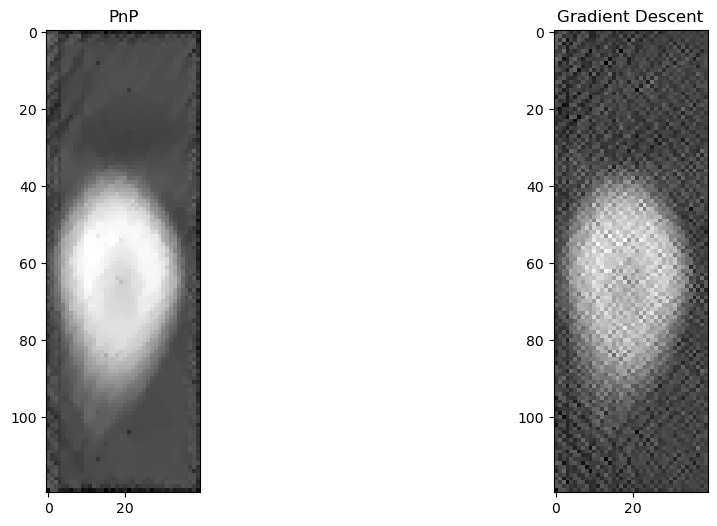

In [521]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x_pnp.reshape(120, 40).get(), cmap="gray")
ax[0].set_title("PnP")
ax[1].imshow(x_gd.reshape(120, 40).get(), cmap="gray")
ax[1].set_title("Gradient Descent")
plt.show()


In [595]:
sinogram = torch.tensor(y, device=device)

/tmp/ipykernel_148785/4135696002.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sinogram = torch.tensor(y, device=device)


In [596]:
#reconstruction using posterior sampling with DDPM
device = 'cuda:0'
y = sinogram.to(device)
print('shape of y', y.shape)
generated_list = []
chainrule = False
if chainrule :
    linearoperator = xray

    for i in range(10):
        generated, _ = posterior_generate_image(model.to(device), 1, 1, (120, 40), linearoperator, y)
        generated_list.append(generated)

else:
    linearoperator = A_torch
    print(linearoperator.shape)
    generated, _ = posterior_generate_image(model.to(device), 99, 1, (120, 40), linearoperator, y)
    generated_list.append(generated)

generated_list = np.array(generated_list)
    

shape of y torch.Size([100])
torch.Size([100, 4800])


  0%|          | 0/1000 [00:00<?, ?it/s]

res tensor(0.1418, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1419, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1416, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1417, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1416, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1415, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1414, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1414, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1412, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1410, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1412, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1410, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1410, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1407, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1407, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1407, device='cuda:0', grad_fn=<DivBackward0>)
res tensor(0.1408, device='cuda:0', grad

(120, 40)


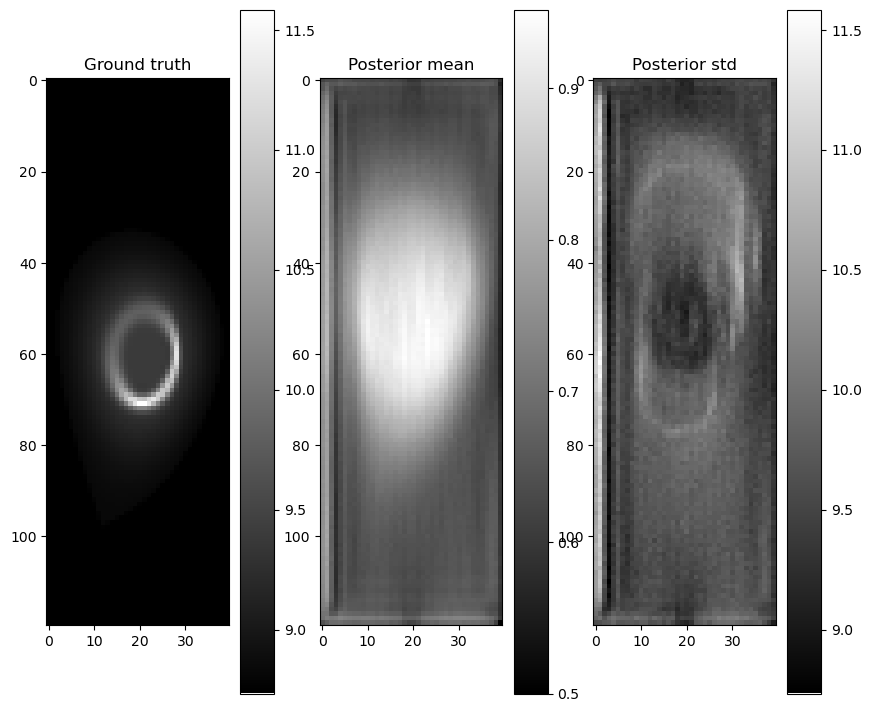

In [597]:
generated_list = generated_list.squeeze()
fig, ax = plt.subplots(1, 3, figsize=(10, 15))

c0 = ax[0].imshow(x_gt_np, cmap="gray")
ax[0].set_title("Ground truth")

posterior_mean = np.mean(generated_list, axis=0)

c1 = ax[1].imshow(posterior_mean.squeeze(), cmap="gray")
ax[1].set_title("Posterior mean")

std_image = np.std(generated_list, axis=0)
print(std_image.shape)
ax[2].imshow(rescale(std_image).squeeze(), cmap="gray")
ax[2].set_title("Posterior std")
fig.colorbar(c1, ax= ax[2])
fig.colorbar(c0, ax= ax[1])
fig.colorbar(c1, ax= ax[0])

NameError: name 'x_pnp' is not defined

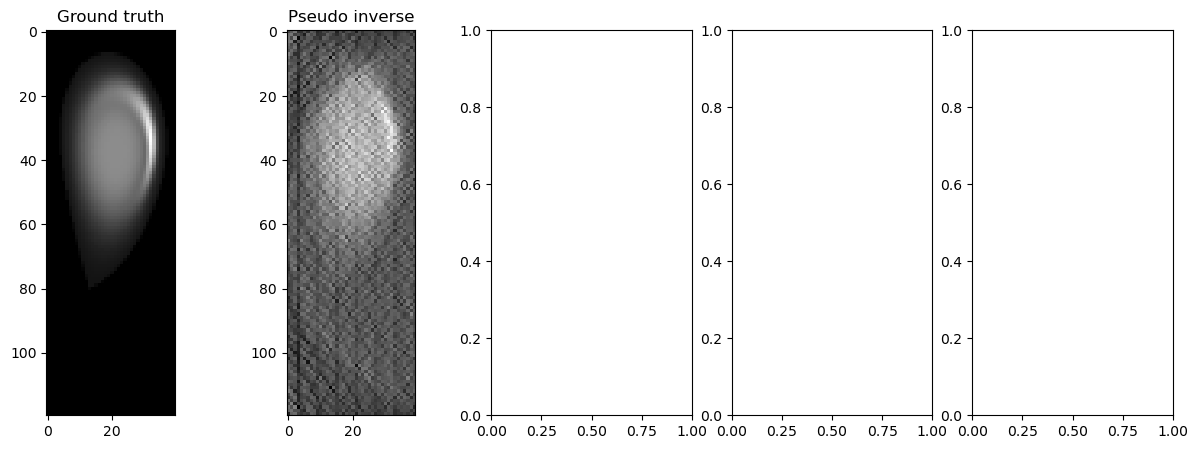

In [391]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))

c0 = ax[0].imshow(x_gt_np, cmap="gray")
ax[0].set_title("Ground truth")

ax[1].imshow(x_rec_pinv.get().reshape(120, 40), cmap="gray")
ax[1].set_title("Pseudo inverse")

#one sample
ax[2].imshow(x_pnp.reshape(120, 40).get(), cmap="gray")
ax[2].set_title("WCRR")
generated_list = np.array(generated_list)

posterior_mean = np.mean(generated_list, axis=0)
c1 = ax[3].imshow(rescale(posterior_mean.squeeze()), cmap="gray")
ax[3].set_title("Posterior mean")

std_image = np.std(generated_list, axis=0)
print(std_image.shape)
ax[4].imshow(rescale(std_image).squeeze(), cmap="gray")
ax[4].set_title("Posterior std")
fig.colorbar(c1, ax= ax[3])
fig.colorbar(c0, ax= ax[0])

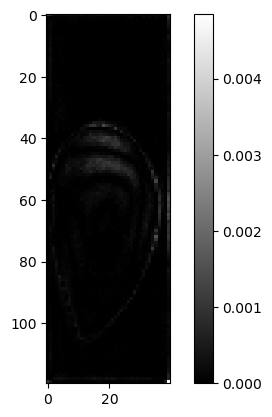

In [535]:
plt.imshow((x_gt_np.squeeze() - posterior_mean.squeeze())**2, cmap='gray')
plt.colorbar()

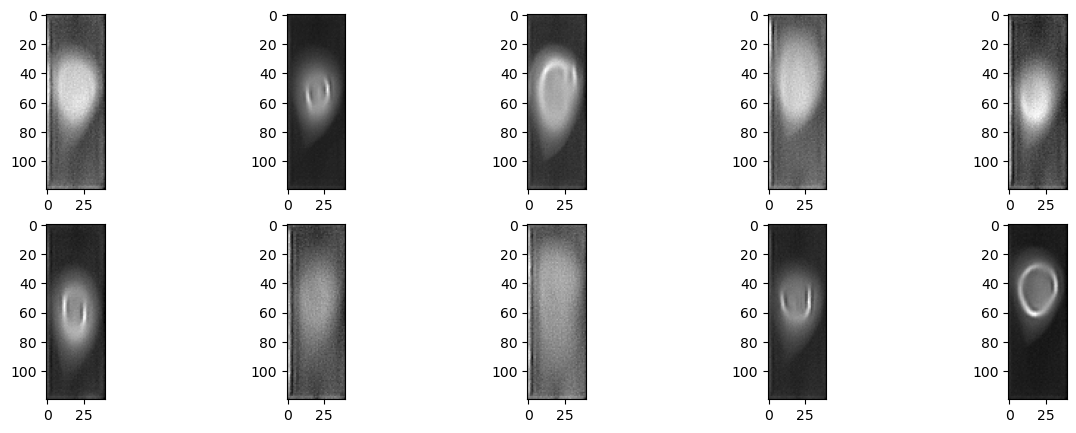

In [598]:
#show_images_rescale(generated, "final results")
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(5):
    ax[0, i].imshow(generated_list[i].squeeze(), cmap="gray")
    ax[1, i].imshow(generated_list[i+5].squeeze(), cmap="gray")

plt.show()

## Try a version for signals (1D)

In [ ]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding for 1D sequences
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

Text(0.5, 1.0, 'Sinusoidal embedding')

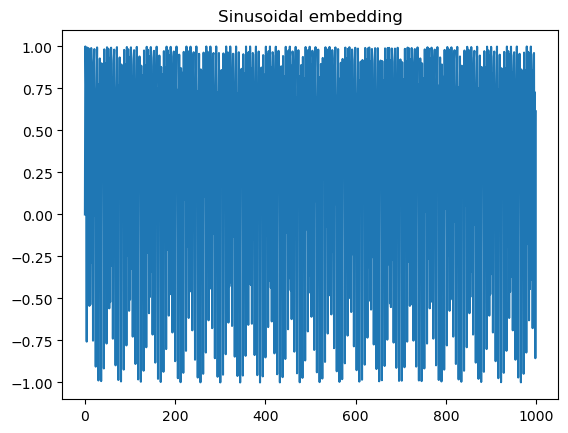

In [ ]:
# test
embedding = sinusoidal_embedding(1000, 100)
#plt.plot(embedding[:,0].numpy())
#plt.title("Sinusoidal embedding")

In [ ]:
class MyConv1D(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv1D, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv1d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out

In [ ]:
def MyTinyBlock1D(size, in_c, out_c):
    return nn.Sequential(MyConv1D(size, in_c, out_c), 
                         MyConv1D(size, out_c, out_c), 
                         MyConv1D(size, out_c, out_c))

def MyTinyUp1D(size, in_c):
    return nn.Sequential(MyConv1D(size, in_c, in_c//2), 
                         MyConv1D(size, in_c//2, in_c//4), 
                         MyConv1D(size, in_c//4, in_c//4))

In [ ]:
class MyTinyUNet1D(nn.Module):
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet1D, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock1D(size, in_c, 10)
        self.down1 = nn.Conv1d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock1D(size//2, 10, 20)
        self.down2 = nn.Conv1d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock1D(size//4, 20, 40)
        self.down3 = nn.Conv1d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv1D(size//8, 40, 20),
            MyConv1D(size//8, 20, 20),
            MyConv1D(size//8, 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose1d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp1D(size//4, 80)
        self.up2 = nn.ConvTranspose1d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp1D(size//2, 40)
        self.up3 = nn.ConvTranspose1d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock1D(size, 20, 10)
        self.conv_out = nn.Conv1d(10, out_c, 3, 1, 1)

    def forward(self, x, t): # x is (bs, in_c, size) t is (bs)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1))  # (bs, 10, size/2)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1))  # (bs, 20, size/4)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1))  # (bs, 40, size/8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1))  # (bs, 40, size/8)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (bs, 80, size/8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1))  # (bs, 20, size/8)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (bs, 40, size/4)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1))  # (bs, 10, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (bs, 20, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1))  # (bs, 10, size)
        out = self.conv_out(out)  # (bs, out_c, size)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))


In [ ]:
# Define input parameters
batch_size = 8
input_channels = 1
output_channels = 1
signal_length = 32
n_steps = 1000
time_emb_dim = 100

# Create random input signal and time steps
x = torch.randn(batch_size, input_channels, signal_length)
t = torch.randint(0, n_steps, (batch_size,))

# Instantiate the MyTinyUNet1D model
model = MyTinyUNet1D(in_c=input_channels, out_c=output_channels, size=signal_length, n_steps=n_steps, time_emb_dim=time_emb_dim)

# Pass the input signal and time steps through the model
output = model(x, t)

# Print the shape of the output
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([8, 1, 32])
Output shape: torch.Size([8, 1, 32])


In [ ]:
class DDPM1D(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device='cuda:0') -> None:
        super(DDPM1D, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5  # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5  # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, length)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps]  # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps]  # bs
        s1 = s1.view(-1, 1, 1)  # (bs, 1, 1) for broadcasting
        s2 = s2.view(-1, 1, 1)  # (bs, 1, 1)
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network returns the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        # One step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1 - self.alphas) / self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].view(-1, 1, 1)
        coef_first = 1 / self.alphas ** 0.5
        coef_first_t = coef_first[t].view(-1, 1, 1)
        pred_prev_sample = coef_first_t * (sample - coef_eps_t * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample
    
    def posterior_sample(self, model_output, timestep, sample, linear_operator, y):
        # y is the observation done with the linear operator
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1 - self.alphas) / self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].view(-1, 1, 1)
        coef_first = 1 / self.alphas ** 0.5
        coef_first_t = coef_first[t].view(-1, 1, 1)
        pred_prev_sample = coef_first_t * (sample - coef_eps_t * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        #return pred_prev_sample
    
        with pxrt.Precision(pxrt.Width.SINGLE):
            # convert y to cupy array of shape (,-1)
            N_kernel = int(linear_operator.weight.data.squeeze().shape[0])

            pred_prev_sample_padd = F.pad(pred_prev_sample, (N_kernel//2-1, N//2-1), mode='constant')
            l2_error = torch.sum((y - linear_operator.forward(pred_prev_sample_padd))**2)
            zeta = 1/torch.sqrt(l2_error)
            gradx_l2_error = torch.autograd.grad(outputs=l2_error, inputs=sample)[0]
    
            #pred_prev_sample_cp = cp.array(pred_prev_sample.detach().reshape(-1))
            #Ax0 = torch.tensor(linear_operator.apply(pred_prev_sample_cp)).reshape(y.shape).to(device)
            #l2_error = torch.sum((y - Ax0)**2)
            #zeta = zeta = 1/torch.sqrt(l2_error)
            #gradx_l2_error = torch.autograd.grad(pred_prev_sample_cp, inputs=sample)[0] * torch.tensor(linear_operator.adjoint(y.reshape(-1) - Ax0.reshape(-1))).reshape(sample.shape).to(device)
        
        pred_prev_sample -= .1 * zeta * gradx_l2_error 

        return pred_prev_sample

In [ ]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [ ]:
betas[timesteps]
betas[timesteps].reshape(-1,1,1,1).shape

torch.Size([5, 1, 1, 1])

In [ ]:
network = MyTinyUNet(in_c =1, out_c =1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [ ]:
bs = 5
x = torch.randn(bs,1,32,32).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [ ]:
def training_loop_1d(model, dataloader, optimizer, num_epochs, num_timesteps, device='cuda'):
    """Training loop for DDPM1D"""
    
    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)
            
            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)

            noise_pred = noise_pred.view_as(noise)
            
            loss = F.mse_loss(noise_pred, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()
    
    return losses

In [ ]:
from torch.utils.data import DataLoader, Dataset
class ConstantFunctionDataset(Dataset):
    def __init__(self, num_samples, signal_length, value_range=(0, 1)):
        self.num_samples = num_samples
        self.signal_length = signal_length
        self.value_range = value_range
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        for _ in range(self.num_samples):
            value = torch.FloatTensor(1).uniform_(*self.value_range).item()
            #signal = torch.full((self.signal_length,), value)
            # signal is sin(value * t)
            ts = torch.arange(self.signal_length).float()
            signal = torch.exp(-(ts-256)**2/(10000*value))
            data.append(signal)
        return torch.stack(data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0)  # Add channel dimension

In [ ]:
class PiecewiseConstantFunctionDataset(Dataset):
    def __init__(self, num_samples, signal_length, num_segments, value_range=(0, 1)):
        self.num_samples = num_samples
        self.signal_length = signal_length
        self.num_segments = num_segments
        self.value_range = value_range
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        segment_length = self.signal_length // self.num_segments
        for _ in range(self.num_samples):
            signal = []
            for _ in range(self.num_segments):
                value = torch.FloatTensor(1).uniform_(*self.value_range).item()
                signal.extend([value] * segment_length)
            signal = signal[:self.signal_length]  # Ensure signal length matches exactly
            data.append(torch.tensor(signal))
        return torch.stack(data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0)  # Add channel dimension

In [ ]:
batch_size = 4
input_channels = 1
signal_length = 512 # 512 before
num_samples = 2000
num_epochs = 250
num_timesteps = 1000
time_emb_dim = 100
learning_rate = 1e-4 #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_segments = 4 #for piecewise constant function


# Create dataset and dataloader
constant_dataset = ConstantFunctionDataset(num_samples, signal_length)
piecewise_constant_dataset = PiecewiseConstantFunctionDataset(num_samples, signal_length, num_segments)
dataloader = DataLoader(piecewise_constant_dataset, batch_size=batch_size, shuffle=True)

# Instantiate the MyTinyUNet1D model
unet1d_model = MyTinyUNet1D(in_c=input_channels, out_c=input_channels, size=signal_length, n_steps=num_timesteps, time_emb_dim=time_emb_dim)

# Instantiate the DDPM1D model with the MyTinyUNet1D network
ddpm1d_model = DDPM1D(network=unet1d_model, num_timesteps=num_timesteps, device=device)

# Move model to the appropriate device
ddpm1d_model.to(device)

# numer of parameters
print(f"Number of parameters: {sum(p.numel() for p in ddpm1d_model.parameters() if p.requires_grad)}")



Number of parameters: 99900


In [ ]:
def plot_functions(dataloader, num_functions=10):
    # Set up the plot
    fig, axes = plt.subplots(num_functions, 1, figsize=(10, 2*num_functions))
    
    # Get the first batch of data
    for i, batch in enumerate(dataloader):
        print(i, batch.shape)
        if i >= num_functions:
            break
        
        signal = batch[0].squeeze().numpy()
        axes[i].plot(signal)

    plt.tight_layout()
    plt.show()


0 torch.Size([4, 1, 512])
1 torch.Size([4, 1, 512])
2 torch.Size([4, 1, 512])
3 torch.Size([4, 1, 512])
4 torch.Size([4, 1, 512])
5 torch.Size([4, 1, 512])
6 torch.Size([4, 1, 512])
7 torch.Size([4, 1, 512])
8 torch.Size([4, 1, 512])
9 torch.Size([4, 1, 512])
10 torch.Size([4, 1, 512])


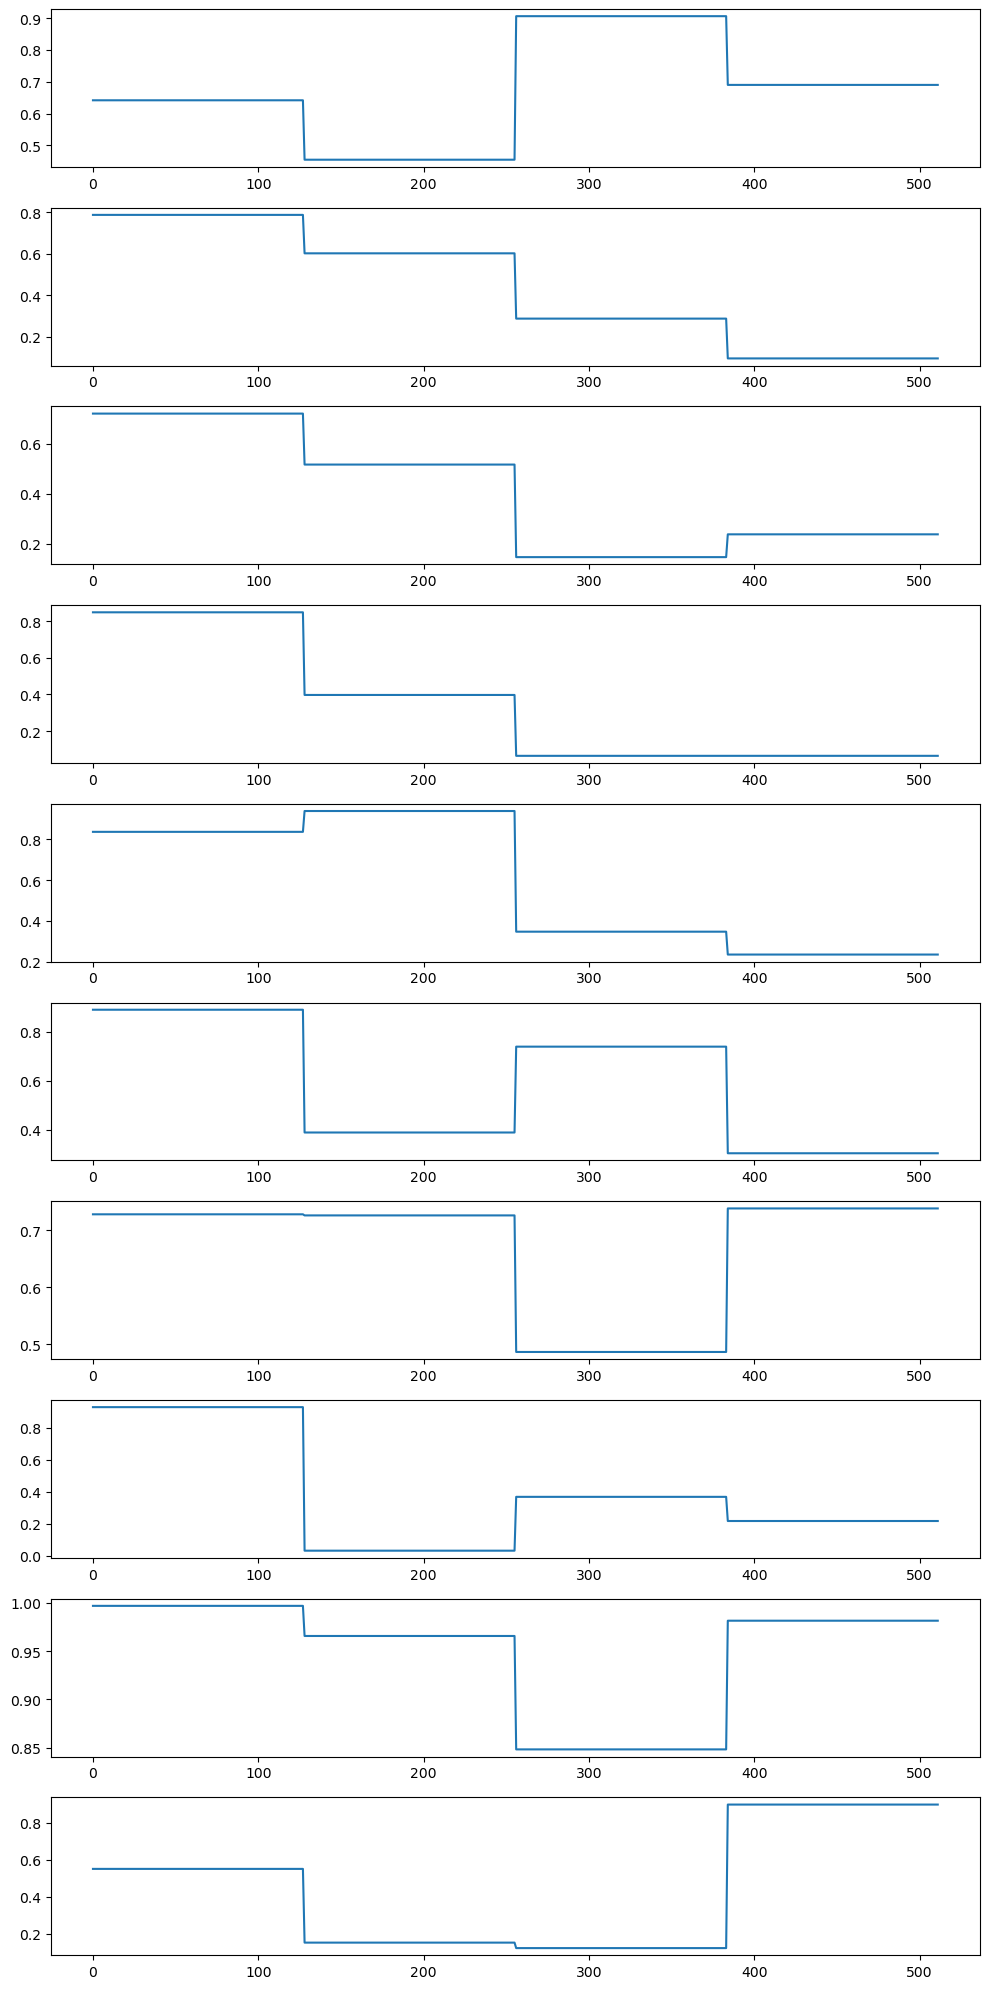

In [ ]:
plot_functions(dataloader, num_functions=10)

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(ddpm1d_model.parameters(), lr=learning_rate)
train = False
if train :
    training_loop_1d(ddpm1d_model, dataloader, optimizer, num_epochs, num_timesteps, device=device)
    # save the model
    torch.save(ddpm1d_model.state_dict(), 'ddpm1d_piecewise_4_1_128_2000_250_1000_100_1e-4.pth')
else:
    #load the model
    ddpm1d_model.load_state_dict(torch.load("ddpm1d_piecewise_4_1_512_2000_250_1000_100_1e-4.pth"))

def generate_signal(ddpm, sample_size, channel, size):
    """Generate the signal from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size).to(device)
        
        for t in tqdm(timesteps):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t == 500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [ ]:
def posterior_generate_signal(ddpm, sample_size, channel, size, linear_operator, y):
    """Generate the signal from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()

    timesteps = list(range(ddpm.num_timesteps))[::-1]
    sample = torch.randn(sample_size, channel, size).to(device)
    sample.requires_grad = True
    
    for t in tqdm(timesteps):
        time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)
        residual = ddpm.reverse(sample, time_tensor)
        sample = ddpm.posterior_sample(residual, time_tensor[0], sample, linear_operator, y)

        if t == 500:
            for i in range(sample_size):
                frames_mid.append(sample[i].detach().cpu())

    for i in range(sample_size):
        frames.append(sample[i].detach().cpu())
        
    return frames, frames_mid

  0%|          | 0/1000 [00:00<?, ?it/s]

Generated Signals:  torch.Size([1, 512])


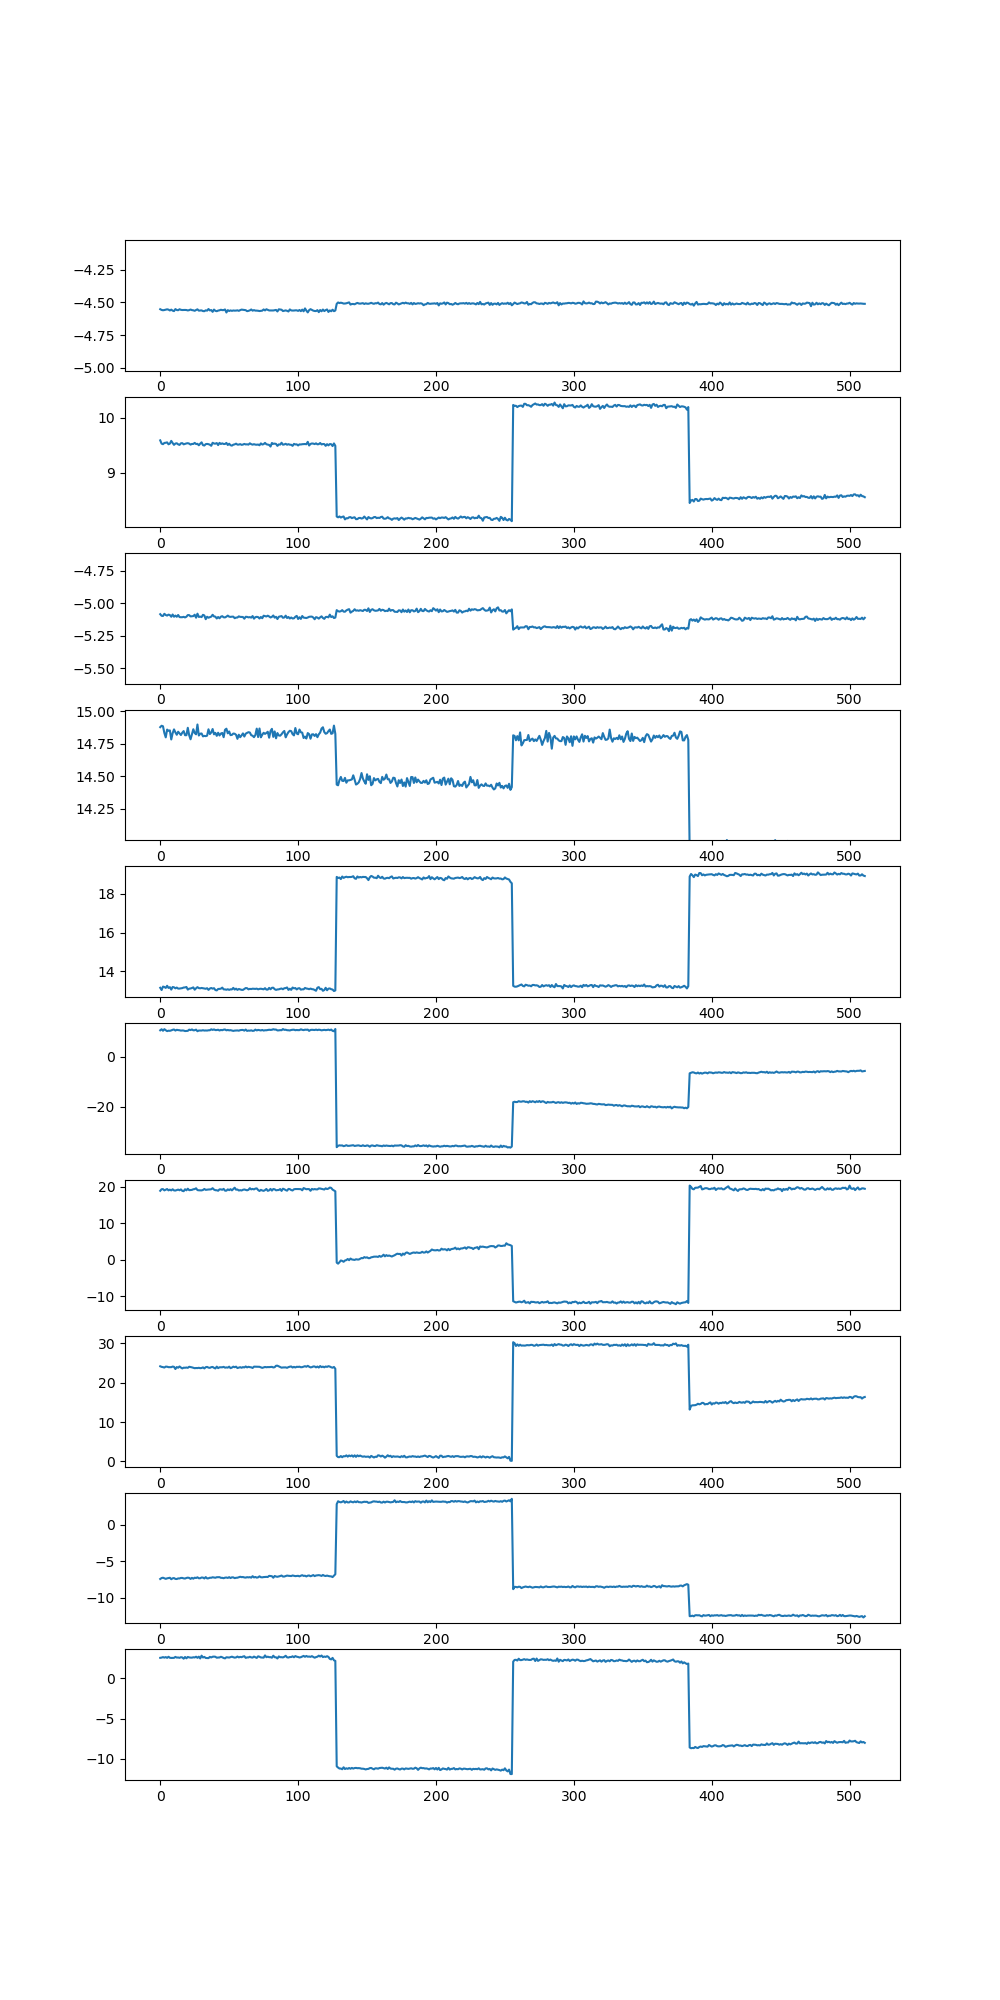

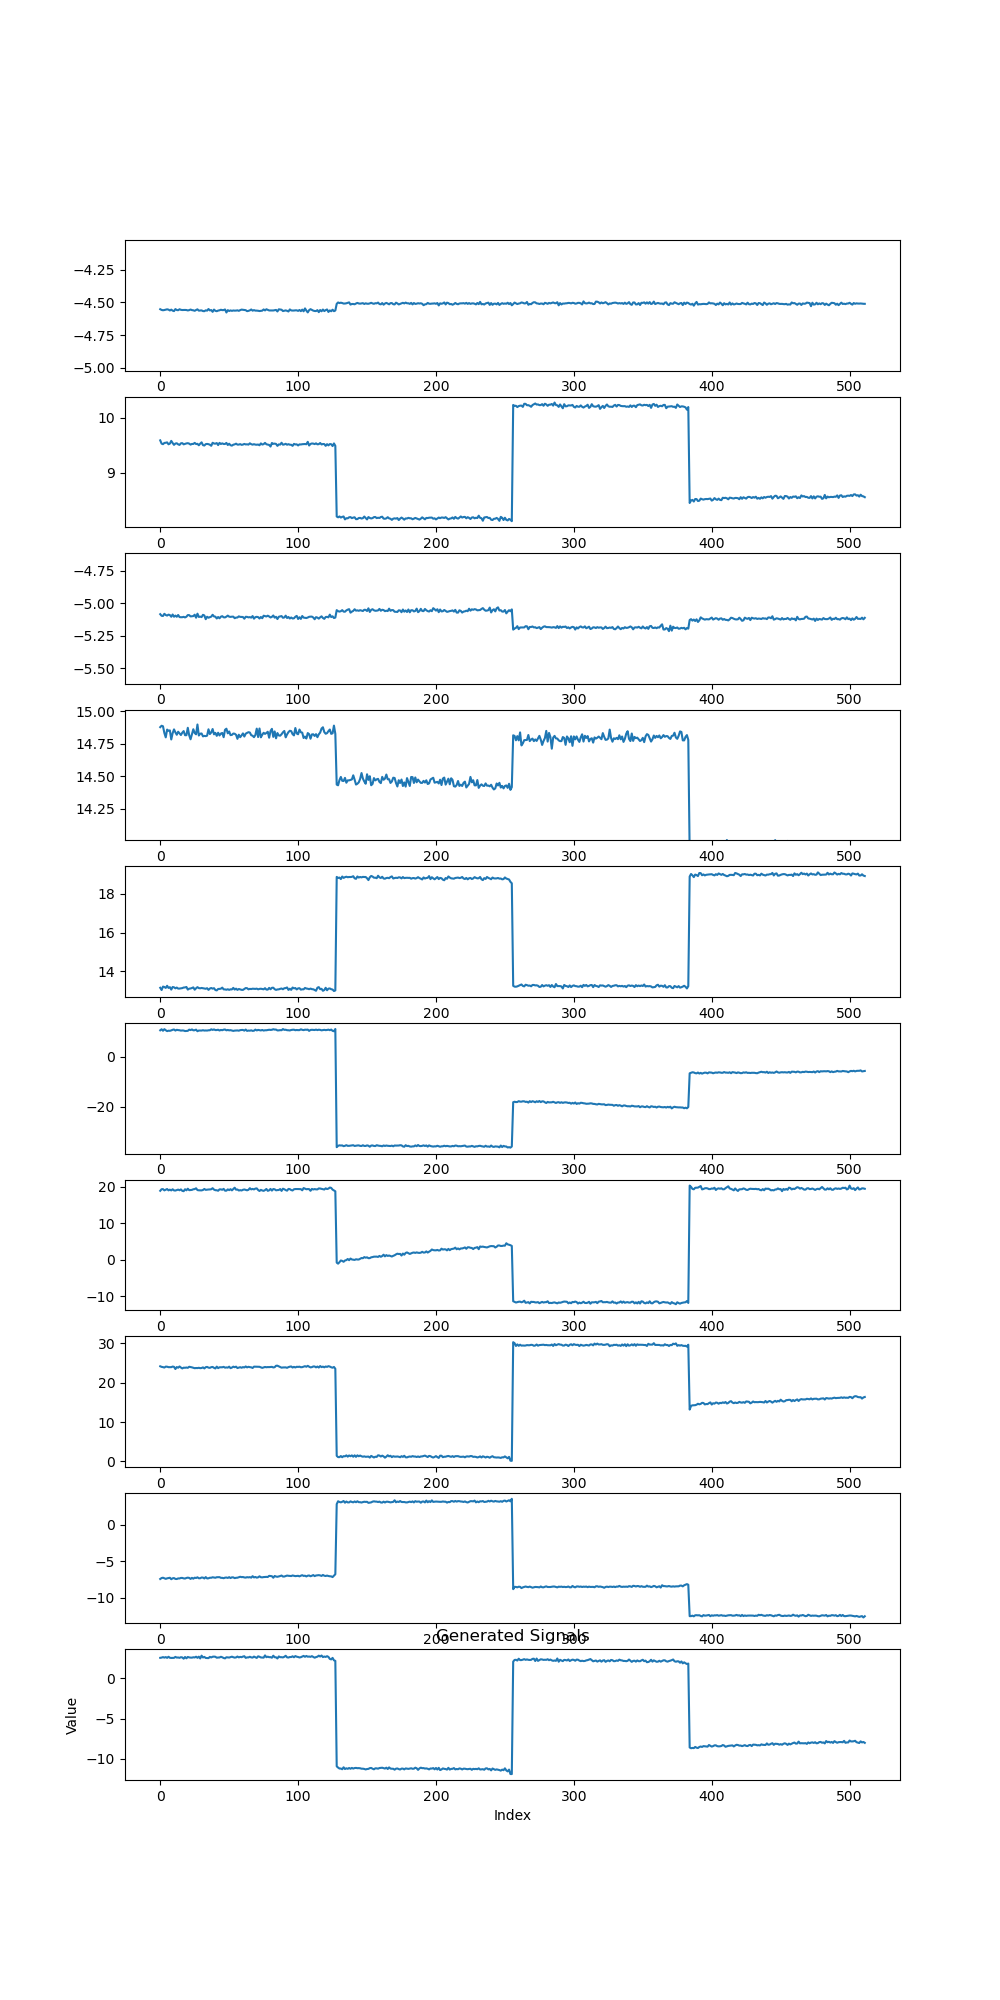

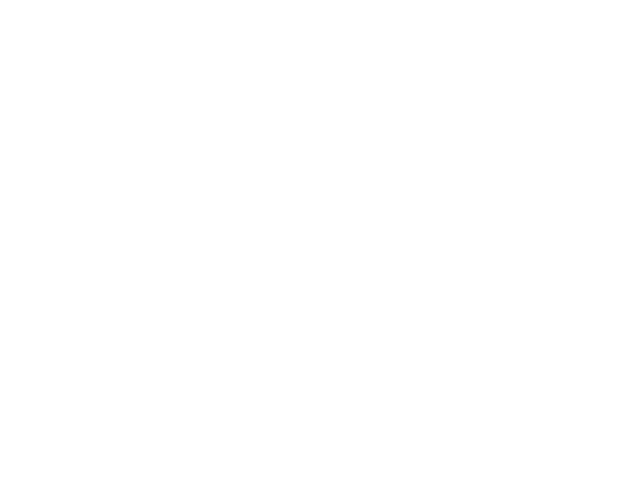

In [ ]:
%matplotlib ipympl
generate, generate_mid = generate_signal(ddpm1d_model.to(device), 10, input_channels, signal_length)
# Plot each tensor in the list
print('Generated Signals: ', generate[0].shape)
plt.clf()
fig, ax = plt.subplots(10, 1, figsize=(10, 20))
for i in range(10):
    ax[i].plot(generate[i].squeeze().numpy())
    # if range is less than 1, set the range to mean -+ 0.5
    if (max(generate[i].squeeze().numpy()) - min(generate[i].squeeze().numpy())) < 1:
        ax[i].set_ylim([np.mean(generate[i].squeeze().numpy()) - 0.5, np.mean(generate[i].squeeze().numpy()) + 0.5])

plt.show()

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Generated Signals')

# Show the plot
plt.show()


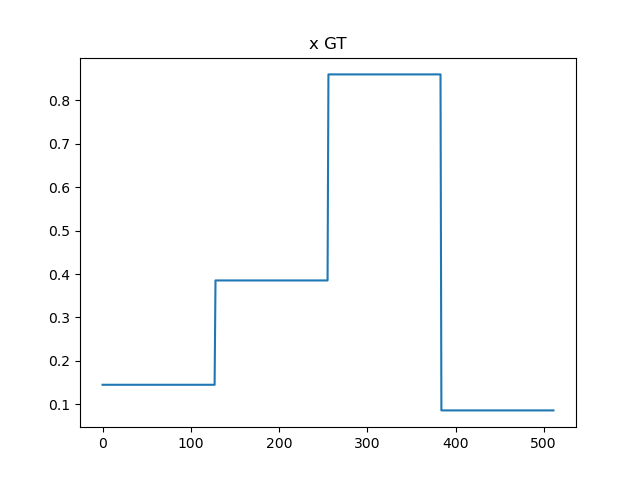

In [ ]:
# inverse problem with 1D data : convolutional operator
# create data y with conv1d from torch

# take x from test dataset of piecewise constant function
test_dataset = PiecewiseConstantFunctionDataset(100, signal_length, num_segments)
plt.figure()
plt.plot(test_dataset[0].squeeze().numpy())
plt.title("x GT")
plt.show()

pytorch y shape torch.Size([1, 1, 512])
pyxu y shape (512,)


/tmp/ipykernel_3258949/1925864862.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/torch/csrc/utils/tensor_new.cpp:261.)
  conv.weight.data = torch.tensor([[k]], dtype=torch.float32).to(device)


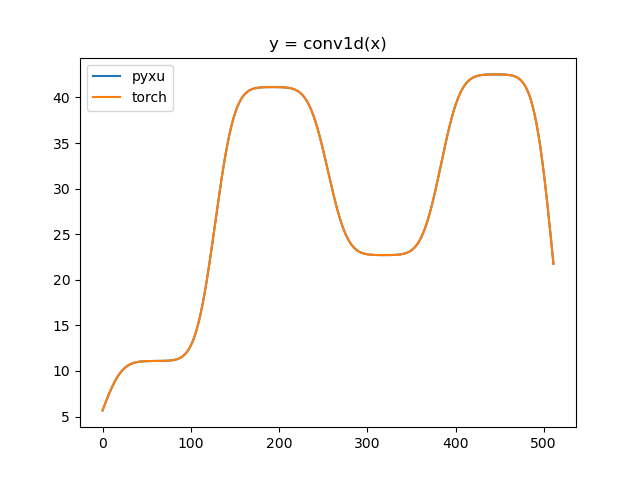

True

In [ ]:
# compute y = conv1d(x)
index_gt = np.random.randint(0, len(test_dataset))
x = test_dataset[index].unsqueeze(0)
x = x.to(device)

from pyxu.operator import Convolve

k = np.array([1.0]*40)
#gaussian kernel
N = 201
k = np.exp(-(np.arange(N)-N//2)**2/600)

op_conv = Convolve(
    arg_shape=x.squeeze().cpu().numpy().shape,
    kernel=k,
    center=(N//2,),
    mode="constant",
)
x_cupy = np.array(x.squeeze().cpu().numpy()).reshape(-1)
y_op = op_conv.apply(x_cupy)
conv = nn.Conv1d(1, 1, N, 1, 1)
conv.weight.data = torch.tensor([[k]], dtype=torch.float32).to(device)
conv.bias.data = torch.tensor([0], dtype=torch.float32).to(device)
padd_x = F.pad(x, (N//2-1, N//2-1), mode='constant')
y = conv(padd_x)
print("pytorch y shape", y.shape)
print("pyxu y shape", y_op.shape)
plt.figure()
plt.plot(y_op, label="pyxu")
plt.plot(y.squeeze().cpu().detach().numpy(), label="torch")
plt.title("y = conv1d(x)")
plt.legend()
plt.show()

# check allclose
np.allclose(y_op, y.squeeze().cpu().detach().numpy())

In [ ]:
# add noise
sigma = 0.1
noise = torch.randn_like(y)*sigma
y_noisy = y + noise
y_op_noisy = (y_op + noise.cpu().numpy()).squeeze()
print("pytorch y shape", y.shape)
print("pyxu y shape", y_op.shape)

pytorch y shape torch.Size([1, 1, 512])
pyxu y shape (512,)


In [ ]:

# posterior sampling
generated, generated_mid = posterior_generate_signal(ddpm1d_model.to(device), 100, input_channels, signal_length, conv, y_noisy)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pseudo inverse')

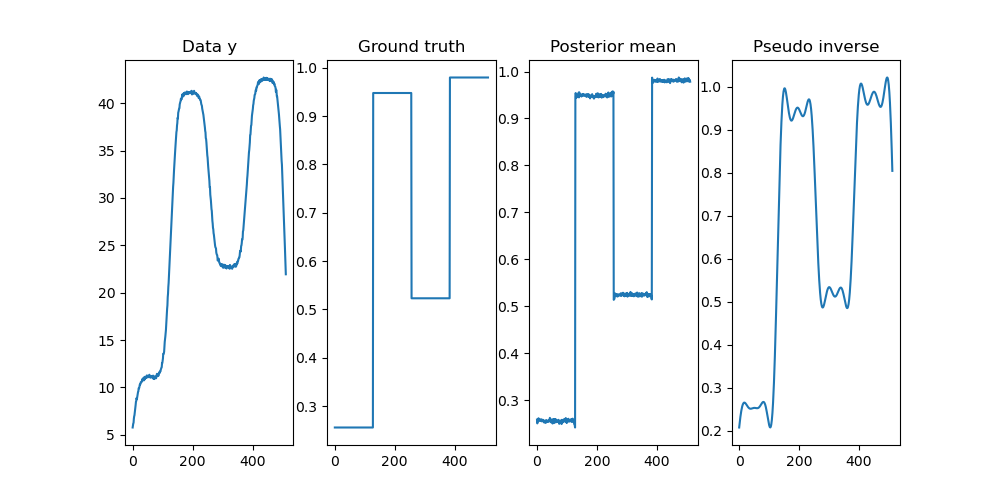

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].plot(y_noisy.squeeze().cpu().detach().numpy())
ax[0].set_title("Data y")

ax[1].plot(x.cpu().squeeze().numpy())
ax[1].set_title("Ground truth")

#one sample
#index = np.random.randint(0, len(generated))
#ax[2].plot(generated[index].squeeze().numpy())
#ax[2].set_title("One Posterior sample")

posterior_mean = torch.mean(torch.stack(generated), dim=0)
ax[2].plot(posterior_mean.squeeze().cpu().numpy())
ax[2].set_title("Posterior mean")

#pyxu pseudo inverse
x_rec_pinv = op_conv.pinv(y_op_noisy, damp=10)

ax[3].plot(x_rec_pinv)
ax[3].set_title("Pseudo inverse")



l2 error pseudo inverse 24.87400039202067
l2 error posterior mean 6.293377553532499


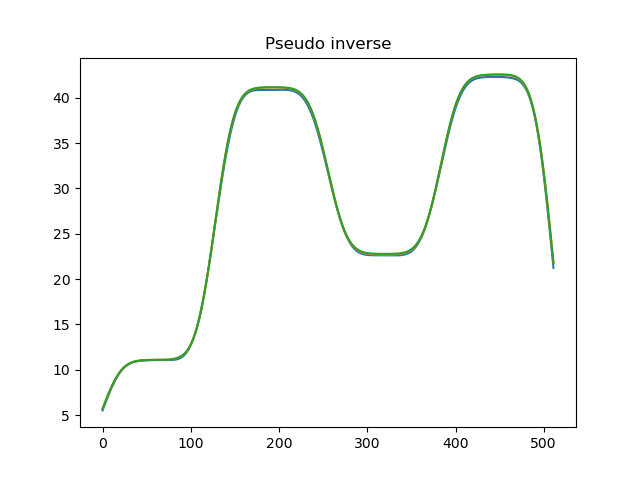

In [ ]:
# data fidelity cost
Ax_rec_pinv = op_conv.apply(x_rec_pinv)
l2_error = np.sum((y_op_noisy - Ax_rec_pinv)**2)

print("l2 error pseudo inverse", l2_error)
Ax_rec_posterior = conv(F.pad(posterior_mean.unsqueeze(0).to(device), (N//2-1, N//2-1), mode='constant'))
l2_error = np.sum((y_op_noisy - Ax_rec_posterior.cpu().detach().numpy().squeeze())**2)
print("l2 error posterior mean", l2_error)

plt.figure()
plt.plot(Ax_rec_pinv)
plt.plot(y_op)
plt.plot(Ax_rec_posterior.detach().cpu().numpy().squeeze())
plt.title("Pseudo inverse")
plt.show()


In [ ]:
class PiecewiseLinearFunctionDataset(Dataset):
    def __init__(self, num_samples, signal_length, num_segments, value_range=(0, 1)):
        self.num_samples = num_samples
        self.signal_length = signal_length
        self.num_segments = num_segments
        self.value_range = value_range
        self.data = self.generate_data()

    def generate_data(self):
        data = []
        segment_length = self.signal_length // self.num_segments
        for _ in range(self.num_samples):
            signal = []
            value_init = torch.FloatTensor(1).uniform_(*self.value_range).item()
            for _ in range(self.num_segments):
                value_next = torch.FloatTensor(1).uniform_(*self.value_range).item()
                segment = torch.linspace(value_init, value_next, segment_length)
                signal.extend(segment)
                value_init = value_next
            signal = signal[:self.signal_length]  # Ensure signal length matches exactly
            data.append(torch.tensor(signal))
        
        return torch.stack(data)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0)  # Add channel dimension

Number of parameters: 99900
0 torch.Size([1, 1, 512])
1 torch.Size([1, 1, 512])
2 torch.Size([1, 1, 512])
3 torch.Size([1, 1, 512])
4 torch.Size([1, 1, 512])
5 torch.Size([1, 1, 512])
6 torch.Size([1, 1, 512])
7 torch.Size([1, 1, 512])
8 torch.Size([1, 1, 512])
9 torch.Size([1, 1, 512])


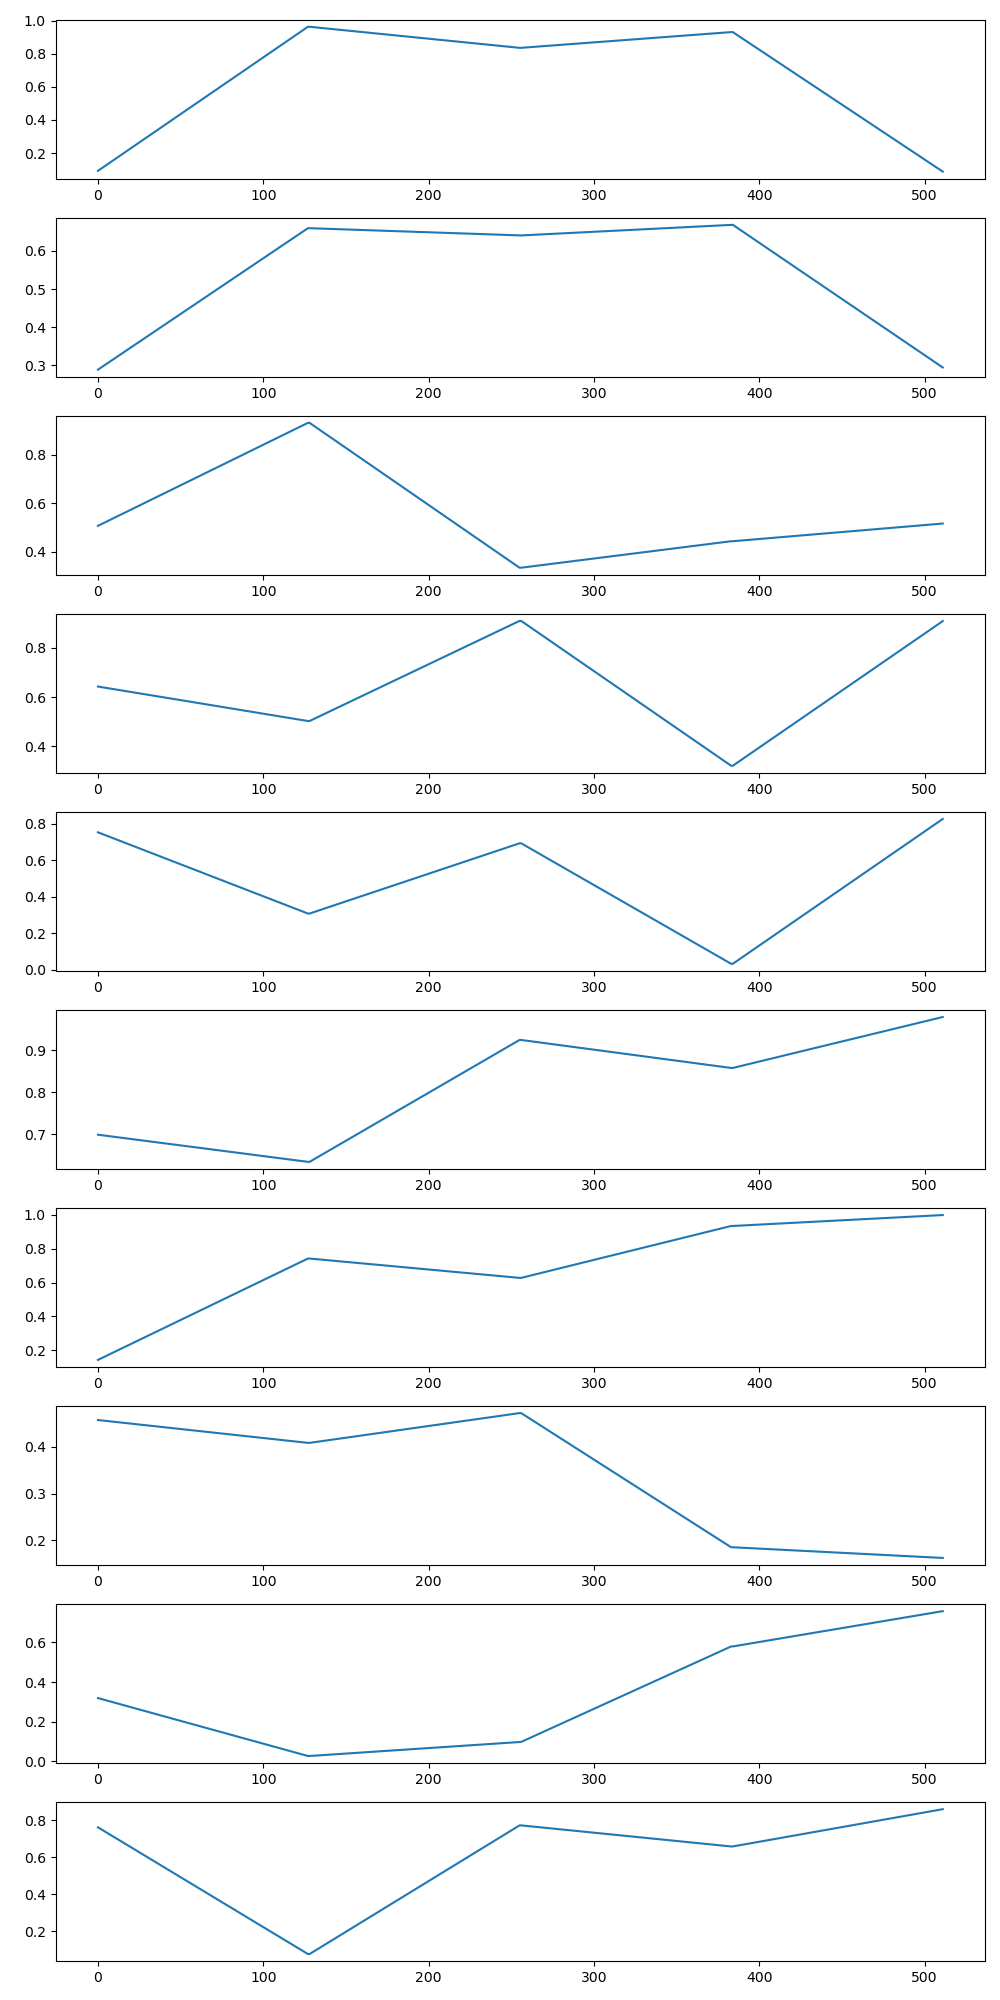

In [ ]:
batch_size = 4
input_channels = 1
signal_length = 512 # 512 before
num_samples = 2000
num_epochs = 250
num_timesteps = 1000
time_emb_dim = 100
learning_rate = 1e-4 #1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_segments = 4 #for piecewise constant function


# Create dataset and dataloader
piecewiselineardataset = PiecewiseLinearFunctionDataset(num_samples, signal_length, num_segments)
dataloader = DataLoader(piecewiselineardataset, batch_size=batch_size, shuffle=True)

# Instantiate the MyTinyUNet1D model
unet1d_model = MyTinyUNet1D(in_c=input_channels, out_c=input_channels, size=signal_length, n_steps=num_timesteps, time_emb_dim=time_emb_dim)

# Instantiate the DDPM1D model with the MyTinyUNet1D network
ddpm1d_model = DDPM1D(network=unet1d_model, num_timesteps=num_timesteps, device=device)

# Move model to the appropriate device
ddpm1d_model.to(device)

# numer of parameters
print(f"Number of parameters: {sum(p.numel() for p in ddpm1d_model.parameters() if p.requires_grad)}")

plot_functions(DataLoader(PiecewiseLinearFunctionDataset(10, signal_length, num_segments), batch_size=1), num_functions=10)

In [ ]:
# Define optimizer
optimizer = torch.optim.Adam(ddpm1d_model.parameters(), lr=learning_rate)
train = False
if train :
    training_loop_1d(ddpm1d_model, dataloader, optimizer, num_epochs, num_timesteps, device=device)
    # save the model
    torch.save(ddpm1d_model.state_dict(), 'ddpm1d_piecewiseLinear_4_1_128_2000_250_1000_100_1e-4.pth')
else:
    #load the model
    ddpm1d_model.load_state_dict(torch.load("/home/haouchat/diffusion/ddpm1d_piecewiseLinear_4_1_128_2000_250_1000_100_1e-4.pth"))

  0%|          | 0/1000 [00:00<?, ?it/s]

Generated Signals:  torch.Size([1, 512])


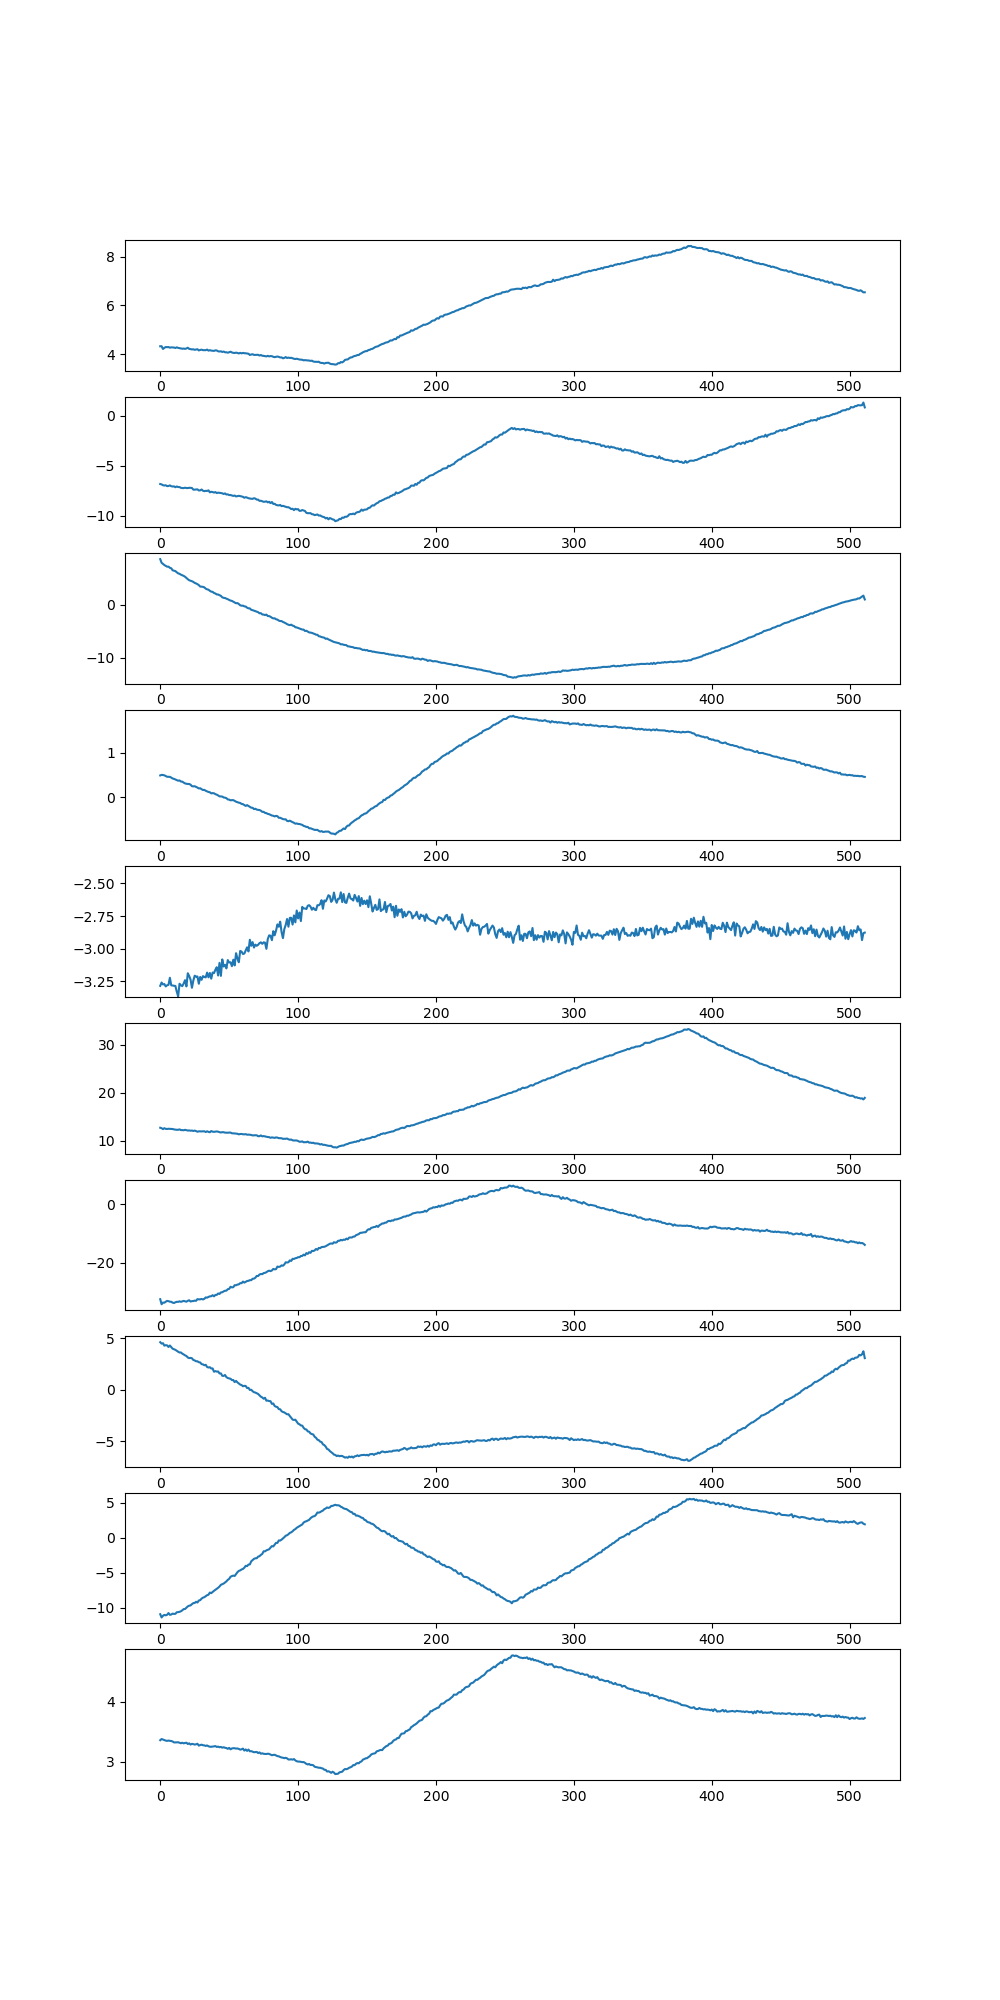

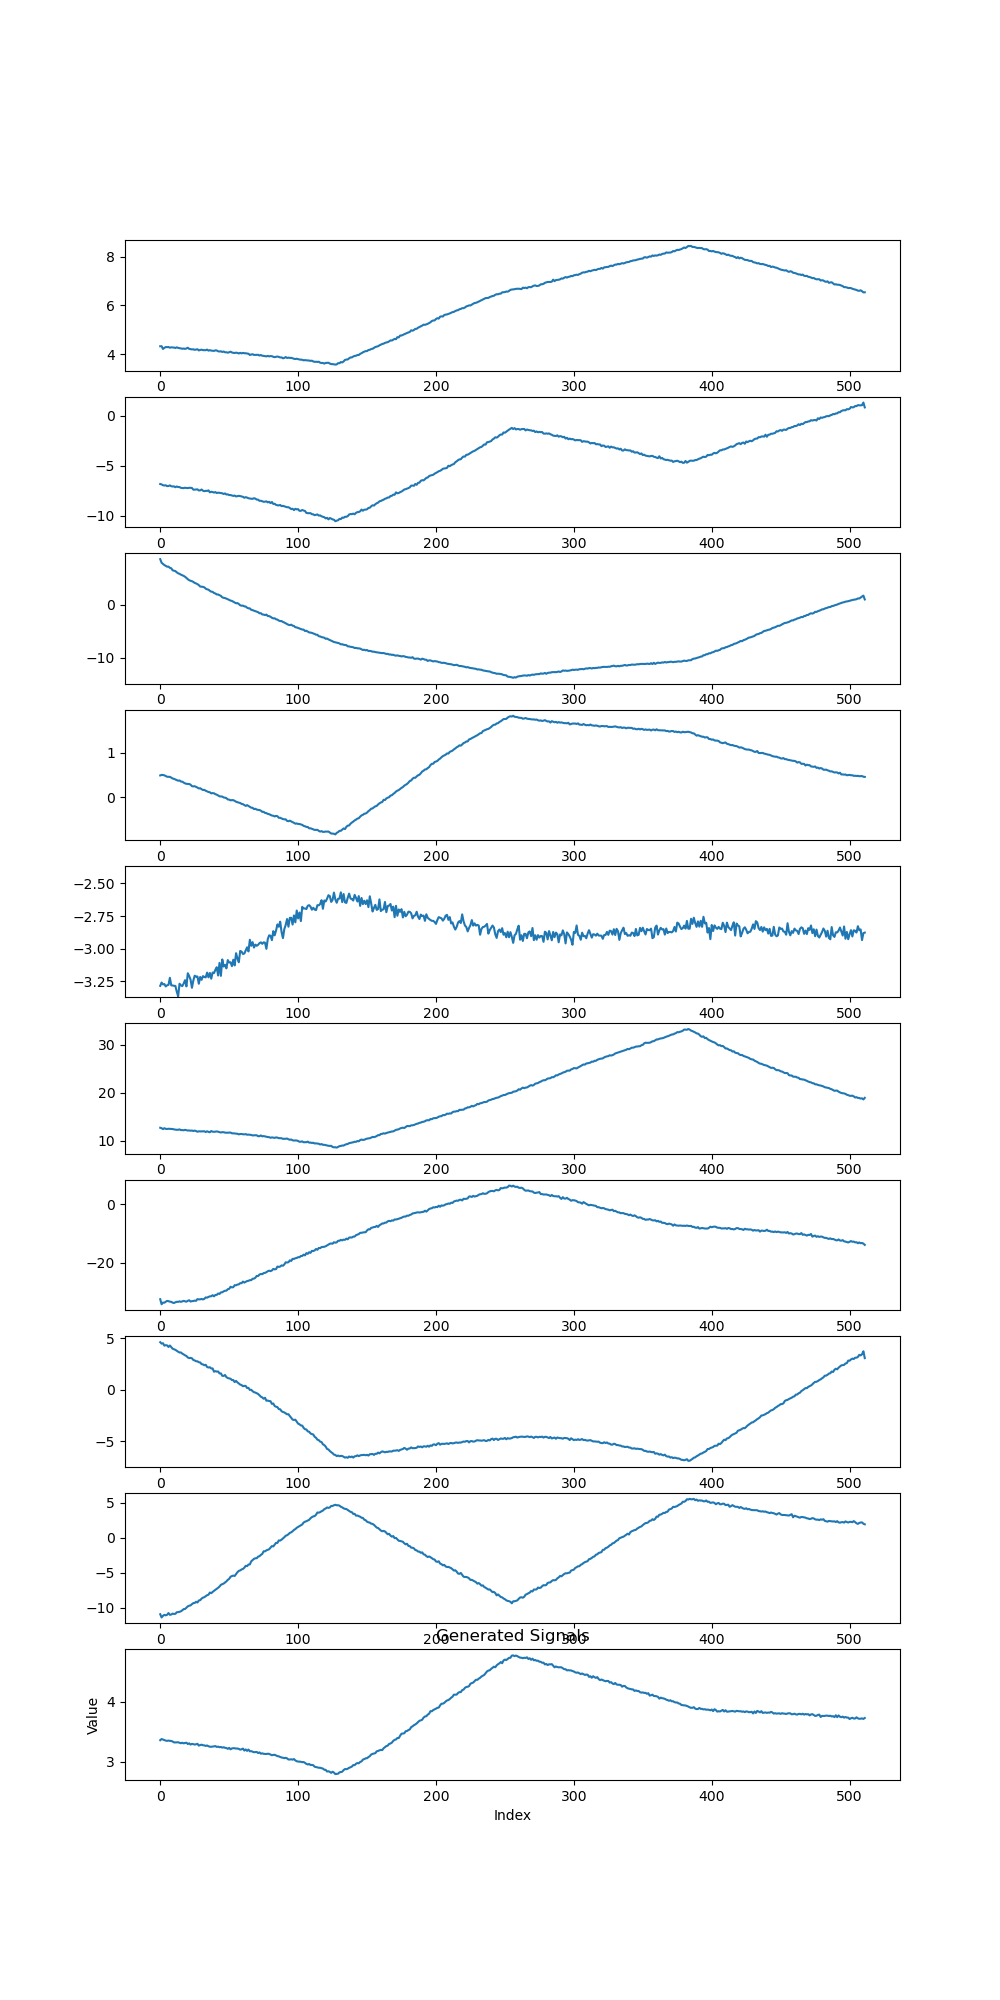

In [ ]:
%matplotlib ipympl
generate, generate_mid = generate_signal(ddpm1d_model.to(device), 10, input_channels, signal_length)
# Plot each tensor in the list
print('Generated Signals: ', generate[0].shape)
plt.clf()
fig, ax = plt.subplots(10, 1, figsize=(10, 20))
for i in range(10):
    ax[i].plot(generate[i].squeeze().numpy())
    # if range is less than 1, set the range to mean -+ 0.5
    if (max(generate[i].squeeze().numpy()) - min(generate[i].squeeze().numpy())) < 1:
        ax[i].set_ylim([np.mean(generate[i].squeeze().numpy()) - 0.5, np.mean(generate[i].squeeze().numpy()) + 0.5])

plt.show()

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Generated Signals')

# Show the plot
plt.show()


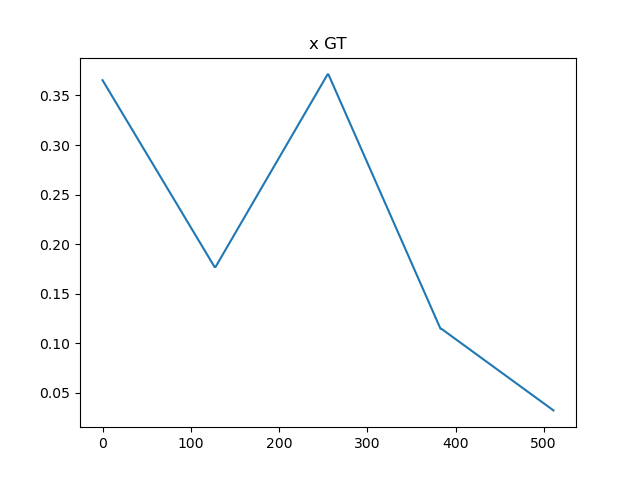

pytorch y shape torch.Size([1, 1, 512])
pyxu y shape (512,)


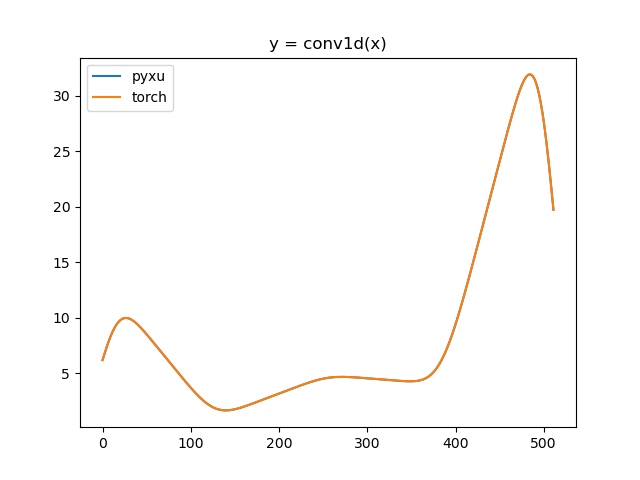

pytorch y shape torch.Size([1, 1, 512])
pyxu y shape (512,)


  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pseudo inverse')

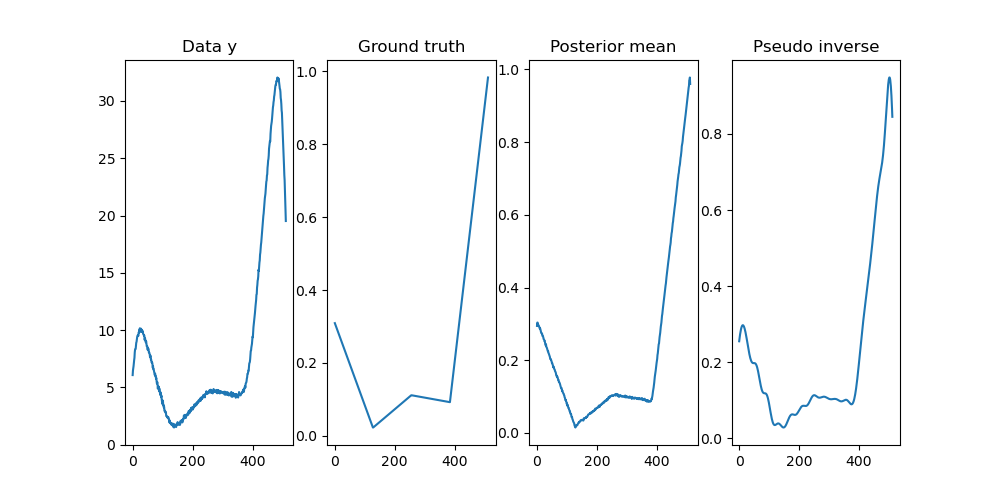

In [ ]:
# inverse problem with 1D data : convolutional operator
# create data y with conv1d from torch

# take x from test dataset of piecewise constant function
test_dataset = PiecewiseLinearFunctionDataset(100, signal_length, num_segments)
plt.figure()
plt.plot(test_dataset[0].squeeze().numpy())
plt.title("x GT")
plt.show()

# compute y = conv1d(x)
index_gt = np.random.randint(0, len(test_dataset))
x = test_dataset[index].unsqueeze(0)
x = x.to(device)

from pyxu.operator import Convolve

k = np.array([1.0]*40)
#gaussian kernel
N = 201
k = np.exp(-(np.arange(N)-N//2)**2/600)

op_conv = Convolve(
    arg_shape=x.squeeze().cpu().numpy().shape,
    kernel=k,
    center=(N//2,),
    mode="constant",
)
x_cupy = np.array(x.squeeze().cpu().numpy()).reshape(-1)
y_op = op_conv.apply(x_cupy)
conv = nn.Conv1d(1, 1, N, 1, 1)
conv.weight.data = torch.tensor([[k]], dtype=torch.float32).to(device)
conv.bias.data = torch.tensor([0], dtype=torch.float32).to(device)
padd_x = F.pad(x, (N//2-1, N//2-1), mode='constant')
y = conv(padd_x)
print("pytorch y shape", y.shape)
print("pyxu y shape", y_op.shape)
plt.figure()
plt.plot(y_op, label="pyxu")
plt.plot(y.squeeze().cpu().detach().numpy(), label="torch")
plt.title("y = conv1d(x)")
plt.legend()
plt.show()

# check allclose
np.allclose(y_op, y.squeeze().cpu().detach().numpy())

# add noise
sigma = 0.1
noise = torch.randn_like(y)*sigma
y_noisy = y + noise
y_op_noisy = (y_op + noise.cpu().numpy()).squeeze()
print("pytorch y shape", y.shape)
print("pyxu y shape", y_op.shape)


# posterior sampling
generated, generated_mid = posterior_generate_signal(ddpm1d_model.to(device), 100, input_channels, signal_length, conv, y_noisy)

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].plot(y_noisy.squeeze().cpu().detach().numpy())
ax[0].set_title("Data y")

ax[1].plot(x.cpu().squeeze().numpy())
ax[1].set_title("Ground truth")

#one sample
#index = np.random.randint(0, len(generated))
#ax[2].plot(generated[index].squeeze().numpy())
#ax[2].set_title("One Posterior sample")

posterior_mean = torch.mean(torch.stack(generated), dim=0)
ax[2].plot(posterior_mean.squeeze().cpu().numpy())
ax[2].set_title("Posterior mean")

#pyxu pseudo inverse
x_rec_pinv = op_conv.pinv(y_op_noisy, damp=1)

ax[3].plot(x_rec_pinv)
ax[3].set_title("Pseudo inverse")